# Goals

# Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math
from gensim.models.wrappers import LdaMallet
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import pickle
import random
import glob

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["font.style"] = "normal"
plt.rcParams["axes.labelcolor"] = "gray"
plt.rcParams["text.color"] = "grey"
plt.rcParams["agg.path.chunksize"] = 101
plt.style.use("seaborn-white")

In [3]:
ROOT = os.path.dirname(os.getcwd()) + "/"

# UNESCO + VDEM Data

In [4]:
unesco_dir = ROOT + "data/UNESCO/"

In [5]:
enroll_file = glob.glob(unesco_dir + "*ENRR*.csv")[0]
staff_file = glob.glob(unesco_dir + "*TCHR*.csv")[0]

In [6]:
enroll = pd.read_csv(enroll_file, header=2)
cols = [col for col in enroll.columns if col.isdigit()]
enroll = enroll[cols]
# enroll = enroll.dropna()
enroll = enroll.drop(["2020", "2021"], axis=1)

In [7]:
staff = pd.read_csv(staff_file, header=2)
cols = [col for col in staff.columns if col.isdigit()]
staff = staff[cols]
# staff = staff.dropna()
staff = staff.drop(["2020", "2021"], axis=1)

In [8]:
vdem = pd.read_csv(ROOT + "/data/VDEM/V-Dem-CY-Full+Others-v12.csv")
vdem = vdem[["year", "v2x_gencs"]]
vdem["vdem"] = vdem.groupby("year")["v2x_gencs"].transform("mean")
vdem = vdem[["year", "vdem"]]
vdem = vdem[(vdem["year"] > 1899) & (vdem["year"] < 2020)]
vdem = vdem.drop_duplicates()
vdem = vdem.astype({"year": str})

/var/folders/wk/syz2_hq141l5z1r4sy2xjj080000gn/T/ipykernel_20334/3583126983.py:1: DtypeWarning: Columns (364,365,366,394,410,821,831,832,930,1235,1252,1481,3063,3282,3283,3338,3340,3344,3345,3347,3348,3349) have mixed types. Specify dtype option on import or set low_memory=False.
  vdem = pd.read_csv(ROOT + "/data/VDEM/V-Dem-CY-Full+Others-v12.csv")


In [9]:
all_df = vdem.merge(
    enroll.mean().rename("enroll"), how="left", left_on="year", right_index=True
)
all_df = all_df.merge(
    staff.mean().rename("staff"), how="left", left_on="year", right_index=True
)
all_df = all_df.astype({"year": int})

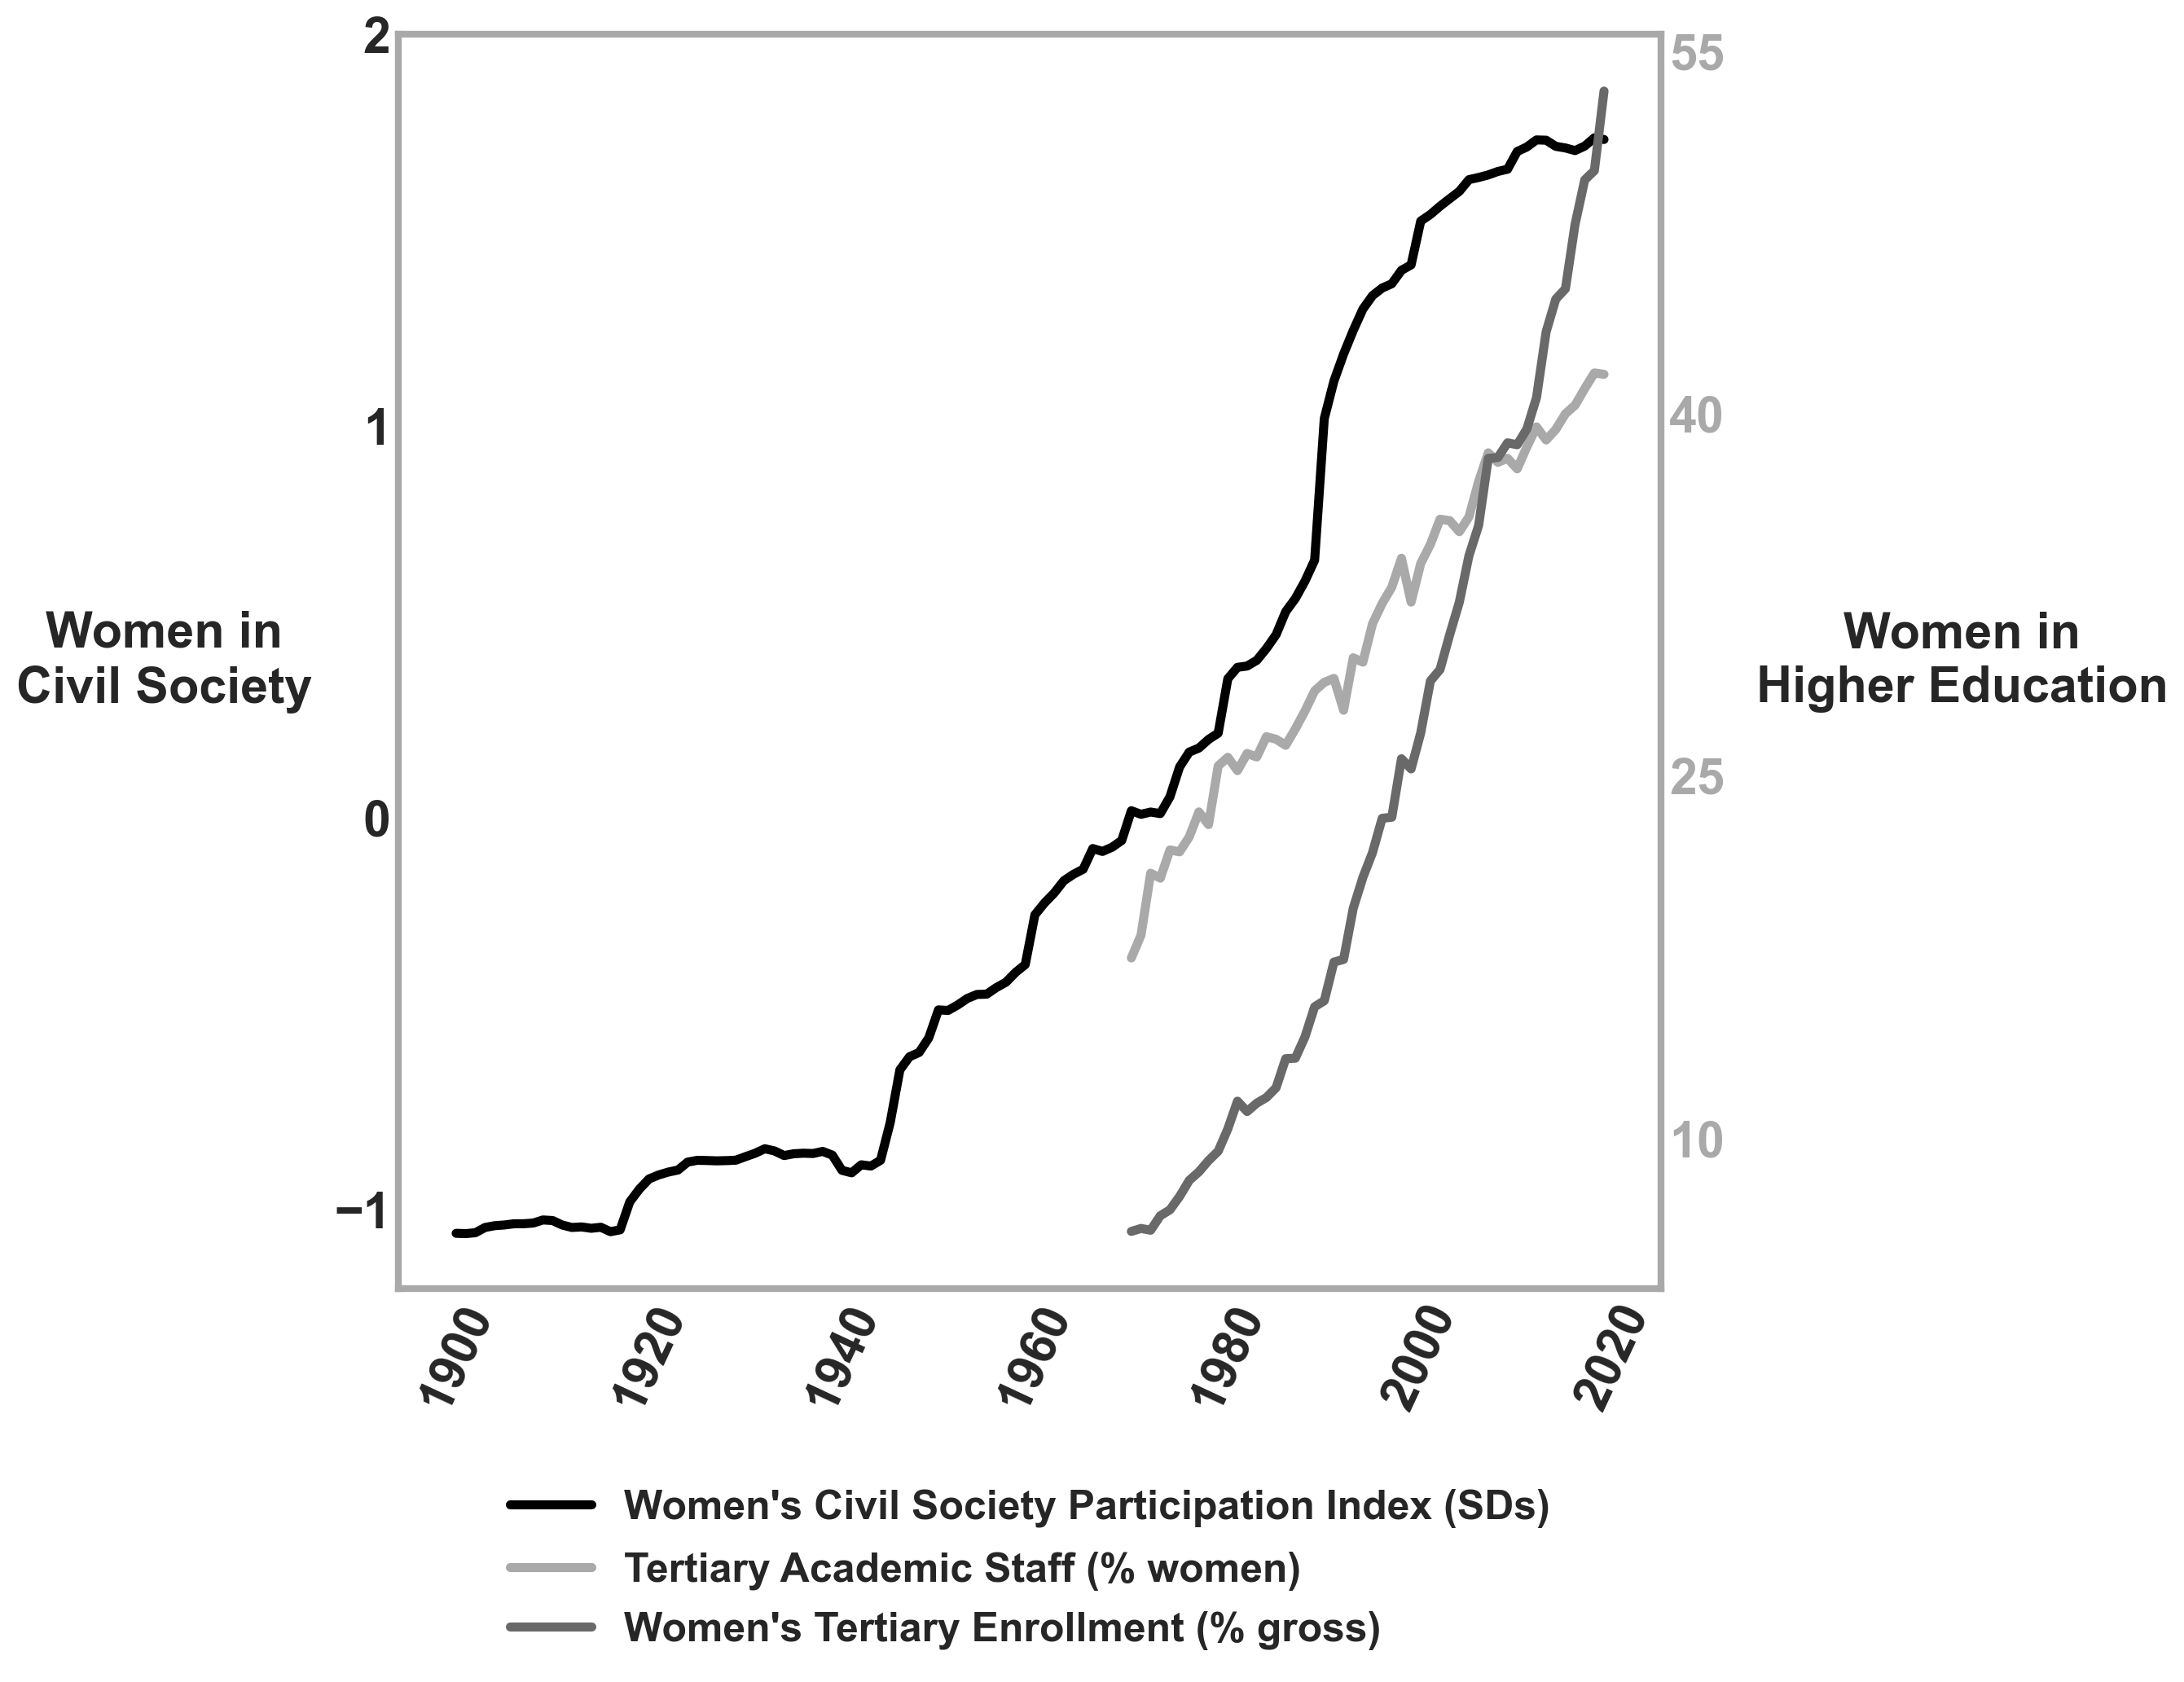

In [10]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 22

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": 18}

ax2 = ax1.twinx()
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")

x = all_df["year"]

y1 = all_df["staff"]
y1_label = "Tertiary Academic Staff (% women)              "

y2 = all_df["enroll"]
y2_label = "Women's Tertiary Enrollment (% gross)               "

y3 = (all_df["vdem"] - all_df["vdem"].mean()) / all_df["vdem"].std()
y3_label = "Women's Civil Society Participation Index (SDs)"


ax2.plot(x, y1, tick_color, label=y1_label, linewidth=4)
ax2.plot(x, y2, edge_color, label=y2_label, linewidth=4)
ax1.plot(x, y3, title_color, label=y3_label, linewidth=4)

ax1.set_ylabel(
    "Women in\nCivil Society",
    rotation=0,
    labelpad=75,
    size=font_size,
    horizontalalignment="center",
    verticalalignment="center",
    weight="bold",
)
ax2.set_ylabel(
    "Women in\nHigher Education",
    rotation=0,
    labelpad=105,
    size=font_size,
    horizontalalignment="center",
    verticalalignment="center",
    weight="bold",
)

ax1.set_yticks(range(-1, 3, 1))
ax2.set_yticks(range(10, 56, 15))

ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
plt.show()

# JSTOR Data

In [11]:
df = pd.read_feather(ROOT + "data/JSTOR/interim/cleaned.feather")

In [12]:
df = df[
    [
        "journal",
        "year",
        "volume",
        "issue",
        "title",
        "tokens",
        "nwords",
        "npages",
        "nauthors",
        "auth1_name",
        "auth1_gender",
        "auth1_probwom",
        "emp",
        "gender_topic",
    ]
]
df.sample(5)

journal  year volume issue  \
105269                     The American Biology Teacher  2017     79     7   
114680                          Music Educators Journal  1968     54     8   
102430  Educational Technology Research and Development  2000     48     2   
41233                        Oxford Review of Education  1998     24     2   
17740                           The Mathematics Teacher  2010    103     6   

                                                    title  \
105269  A Classroom Simulation Activity to Visualize E...   
114680                                 The Aural Approach   
102430  Learner Control over Full and Lean Computer-Ba...   
41233   Level Descriptions in the National Curriculum:...   
17740              Can We Make High School More Relevant?   

                                                   tokens  nwords  npages  \
105269  [classroom, simul, activ, visual, energi, matt...    3741    10.0   
114680  [aural, approach, congratul, jame, hoffren, co...    1549     3.0   
102430  [learner, control, lean, base, instruct, diffe...    9127    17.0   
41233   [oxford, review, educ, vol, level, descript, n...    6796    13.0   
17740   [henri, kranendonk, high, school, relev, view,...    1339     2.0   

        nauthors auth1_name auth1_gender  auth1_probwom  emp  gender_topic  
105269       1.0       LACE        woman           0.63    2      0.000377  
114680       3.0        Eva        woman           0.99    0      0.000878  
102430       2.0      Heidi        woman           1.00   10      0.000173  
41233        2.0     Marian        woman           0.82    0      0.000240  
17740        1.0      Henry          man           0.00    1      0.001230

In [13]:
df['nwords'].describe()

count    243060.000000
mean       3891.390969
std        3700.981666
min           0.000000
25%        1265.000000
50%        2770.000000
75%        5538.000000
max      131850.000000
Name: nwords, dtype: float64

In [14]:
df['npages'].describe()

count    243053.000000
mean          7.911151
std           8.063904
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max         349.000000
Name: npages, dtype: float64

In [15]:
df['ntokens'] = df['tokens'].apply(lambda x: len(x))

In [16]:
df['ntokens'].describe()

count    243060.000000
mean       1975.131252
std        1927.497505
min           0.000000
25%         617.000000
50%        1368.000000
75%        2789.000000
max       83175.000000
Name: ntokens, dtype: float64

Recode Gender

In [17]:
df["auth1_gender"].value_counts()

man      129451
woman     70400
Name: auth1_gender, dtype: int64

In [18]:
df["auth1_gender"] = df["auth1_gender"].fillna("unknown")
df.loc[
    (df["auth1_probwom"] >= 0.45) & (df["auth1_probwom"] <= 0.55), "auth1_gender"
] = "unknown"

In [19]:
df["auth1_gender"].value_counts()

man        129304
woman       69960
unknown     43796
Name: auth1_gender, dtype: int64

In [20]:
df = df.join(pd.get_dummies(df["auth1_gender"]))

Standardize Topic

In [23]:
df["std_gender_topic"] = (df["gender_topic"] - 
                          df["gender_topic"].mean()) / df["gender_topic"].std()

Recode methods

In [24]:
df["std_emp"] = (df["emp"] - df["emp"].mean()) / df["emp"].std()
df["data_article"] = np.where((df["std_emp"] > 0), 1, 0)

Code Decade

In [113]:
df = pd.read_csv(ROOT+"data/processed.csv")

In [114]:
def code_decade(year):
    cen = str(year // 100)
    dec = str(math.floor((year) % 100 / 10) * 10)
    if dec == "0":
        dec = "00"
    return cen + dec + "s"

In [115]:
df["decade"] = df["year"].apply(code_decade)

In [119]:
df.shape[0]

209202

In [120]:
df['journal'].nunique()

163

In [141]:
df['year'].min()

1901

In [143]:
df[df['journal']=="Comparative Education"]['year'].min()

1964

In [144]:
df[df['journal']=="Comparative Education Review"]['year'].min()

1957

In [142]:
df['year'].max()

2010

In [145]:
df[df['journal']=="Comparative Education"]['year'].max()

2010

In [146]:
df[df['journal']=="Comparative Education Review"]['year'].max()

2010

In [127]:
with open(ROOT+"reports/figures/journals.txt", 'w') as f: 
    for i, journal in enumerate(df['journal'].unique()): 
        line = f"{i+1}. {journal}\n"
        f.write(line)

## Trends in Authorship

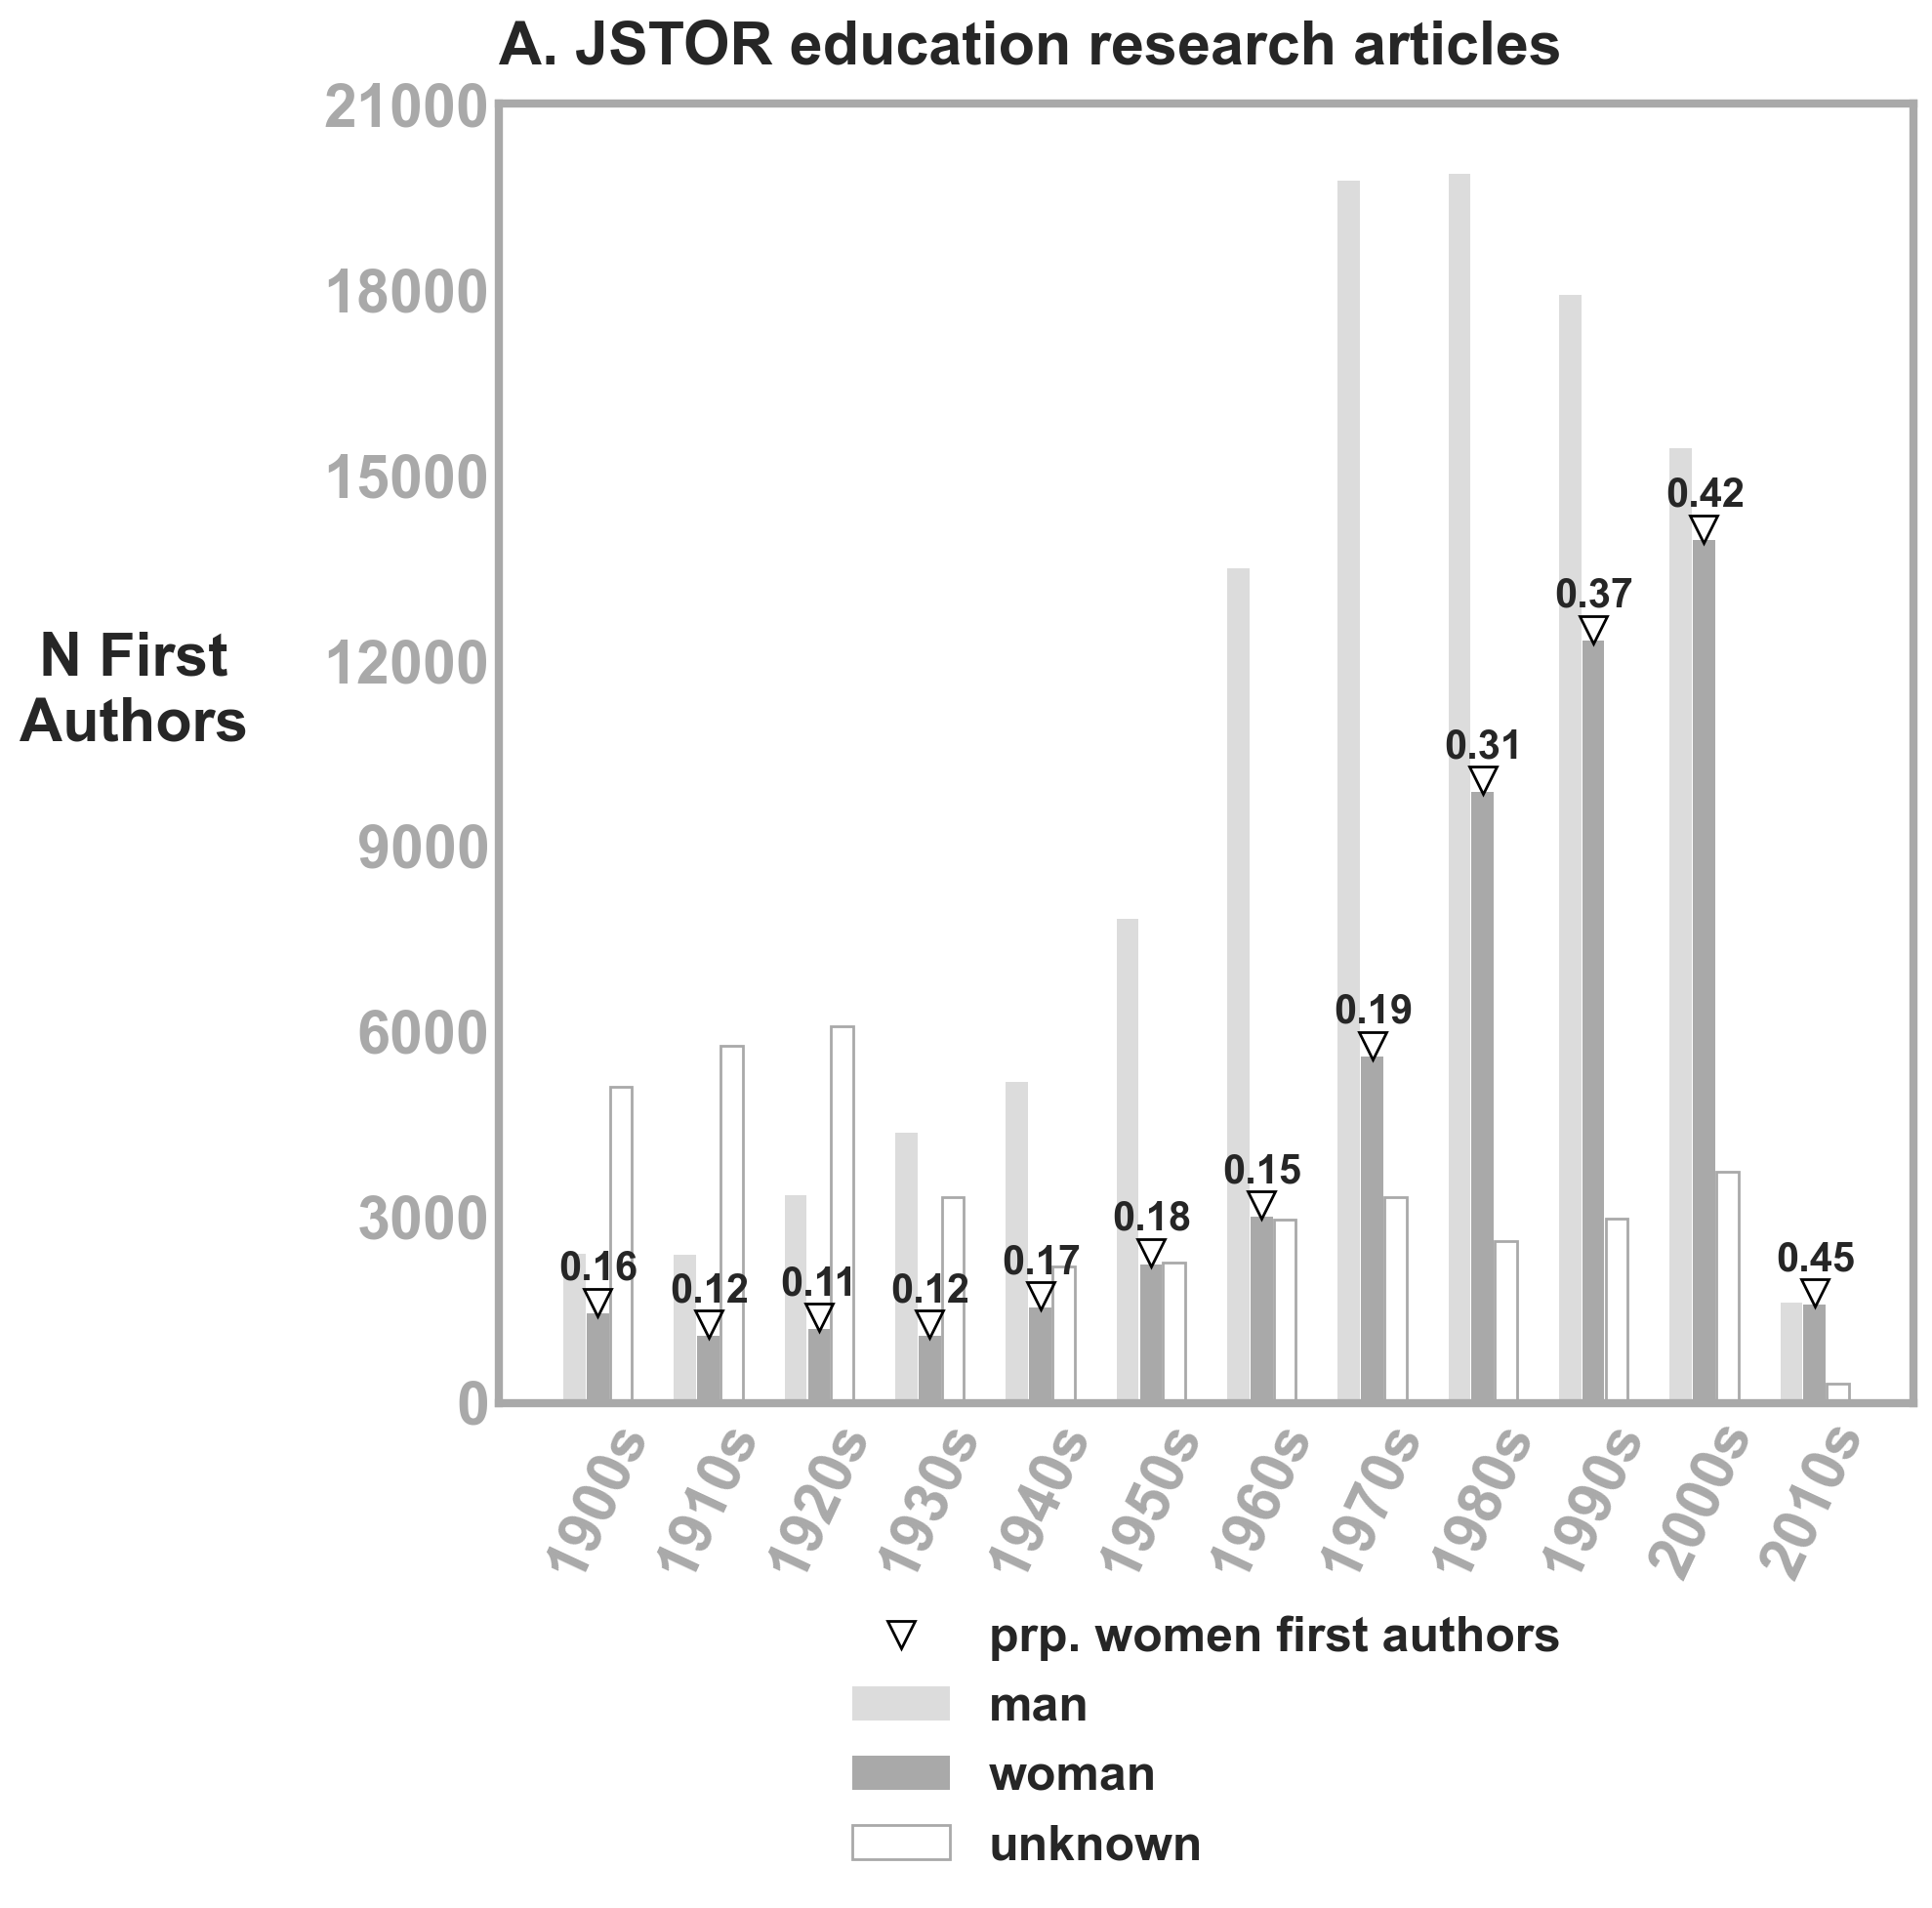

In [116]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 22

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": 18}

decades = sorted(df["decade"].unique())
man = df.groupby("decade")["man"].sum().sort_index()
woman = df.groupby("decade")["woman"].sum().sort_index()
unknown = df.groupby("decade")["unknown"].sum().sort_index()

x = np.arange(len(decades))
width = 0.2

ax1.plot(
    decades,
    woman + 185,
    "-v",
    color="black",
    linewidth=0,
    label="prp. women first authors",
    markersize=10,
    markerfacecolor="none",
)

ax1.bar(x - width - 0.01, 
        man, 
        width, 
        label="man", 
        color="gainsboro")

ax1.bar(x, 
        woman, 
        width, 
        label="woman", 
        color="darkgrey")

ax1.bar(x + width + 0.01,
        unknown,
        width,
        label="unknown",
        color="white",
        edgecolor="darkgrey",
)

prop_woman = list(
    df.groupby("decade")["woman"].sum().sort_index()
    / df["decade"].value_counts().sort_index()
)

for i, pct in enumerate(prop_woman):
    ax1.annotate(
        f"{round(pct,2)}", 
        (x[i] - 0.35, woman[i] + 550), 
        size=15, 
        weight="bold"
    )

ax1.set_ylabel(
    "N First\nAuthors", 
    rotation=0, 
    labelpad=70, 
    size=font_size, 
    fontweight="bold"
)

ax1.set_yticks(range(0, 22000, 3000))
ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)

ax1.set_title("A. JSTOR education research articles", 
              loc="left", 
              size=font_size, 
              fontweight="bold", 
              pad=15)
fig.tight_layout()
plt.show()

In [117]:
df['journal'].nunique()

163

In [31]:
for j in sorted(df['journal'].unique()):
    print(j)

American Educational Research Journal
American Music Teacher
American Secondary Education
Anthropology & Education Quarterly
Architectural Research and Teaching
Art Education
Australian Journal of Environmental Education
British Educational Research Journal
British Journal of Educational Studies
British Journal of Sociology of Education
Brookings Papers on Education Policy
Bulletin of the American Association of Teachers of Italian
Bulletin of the American Association of Teachers of Slavic and East European Languages
Bulletin of the American Association of Teachers of Slavonic and East European Languages
Bulletin of the Council for Research in Music Education
Bulletin of the Music Teachers National Association
Bulletin of the National Association for Nursery Education
California Journal of Teacher Education
Canadian Journal of Education / Revue canadienne de l'éducation
Canadian Journal of Social Work Education / Revue canadienne d'éducation en service social
Change in Higher Education

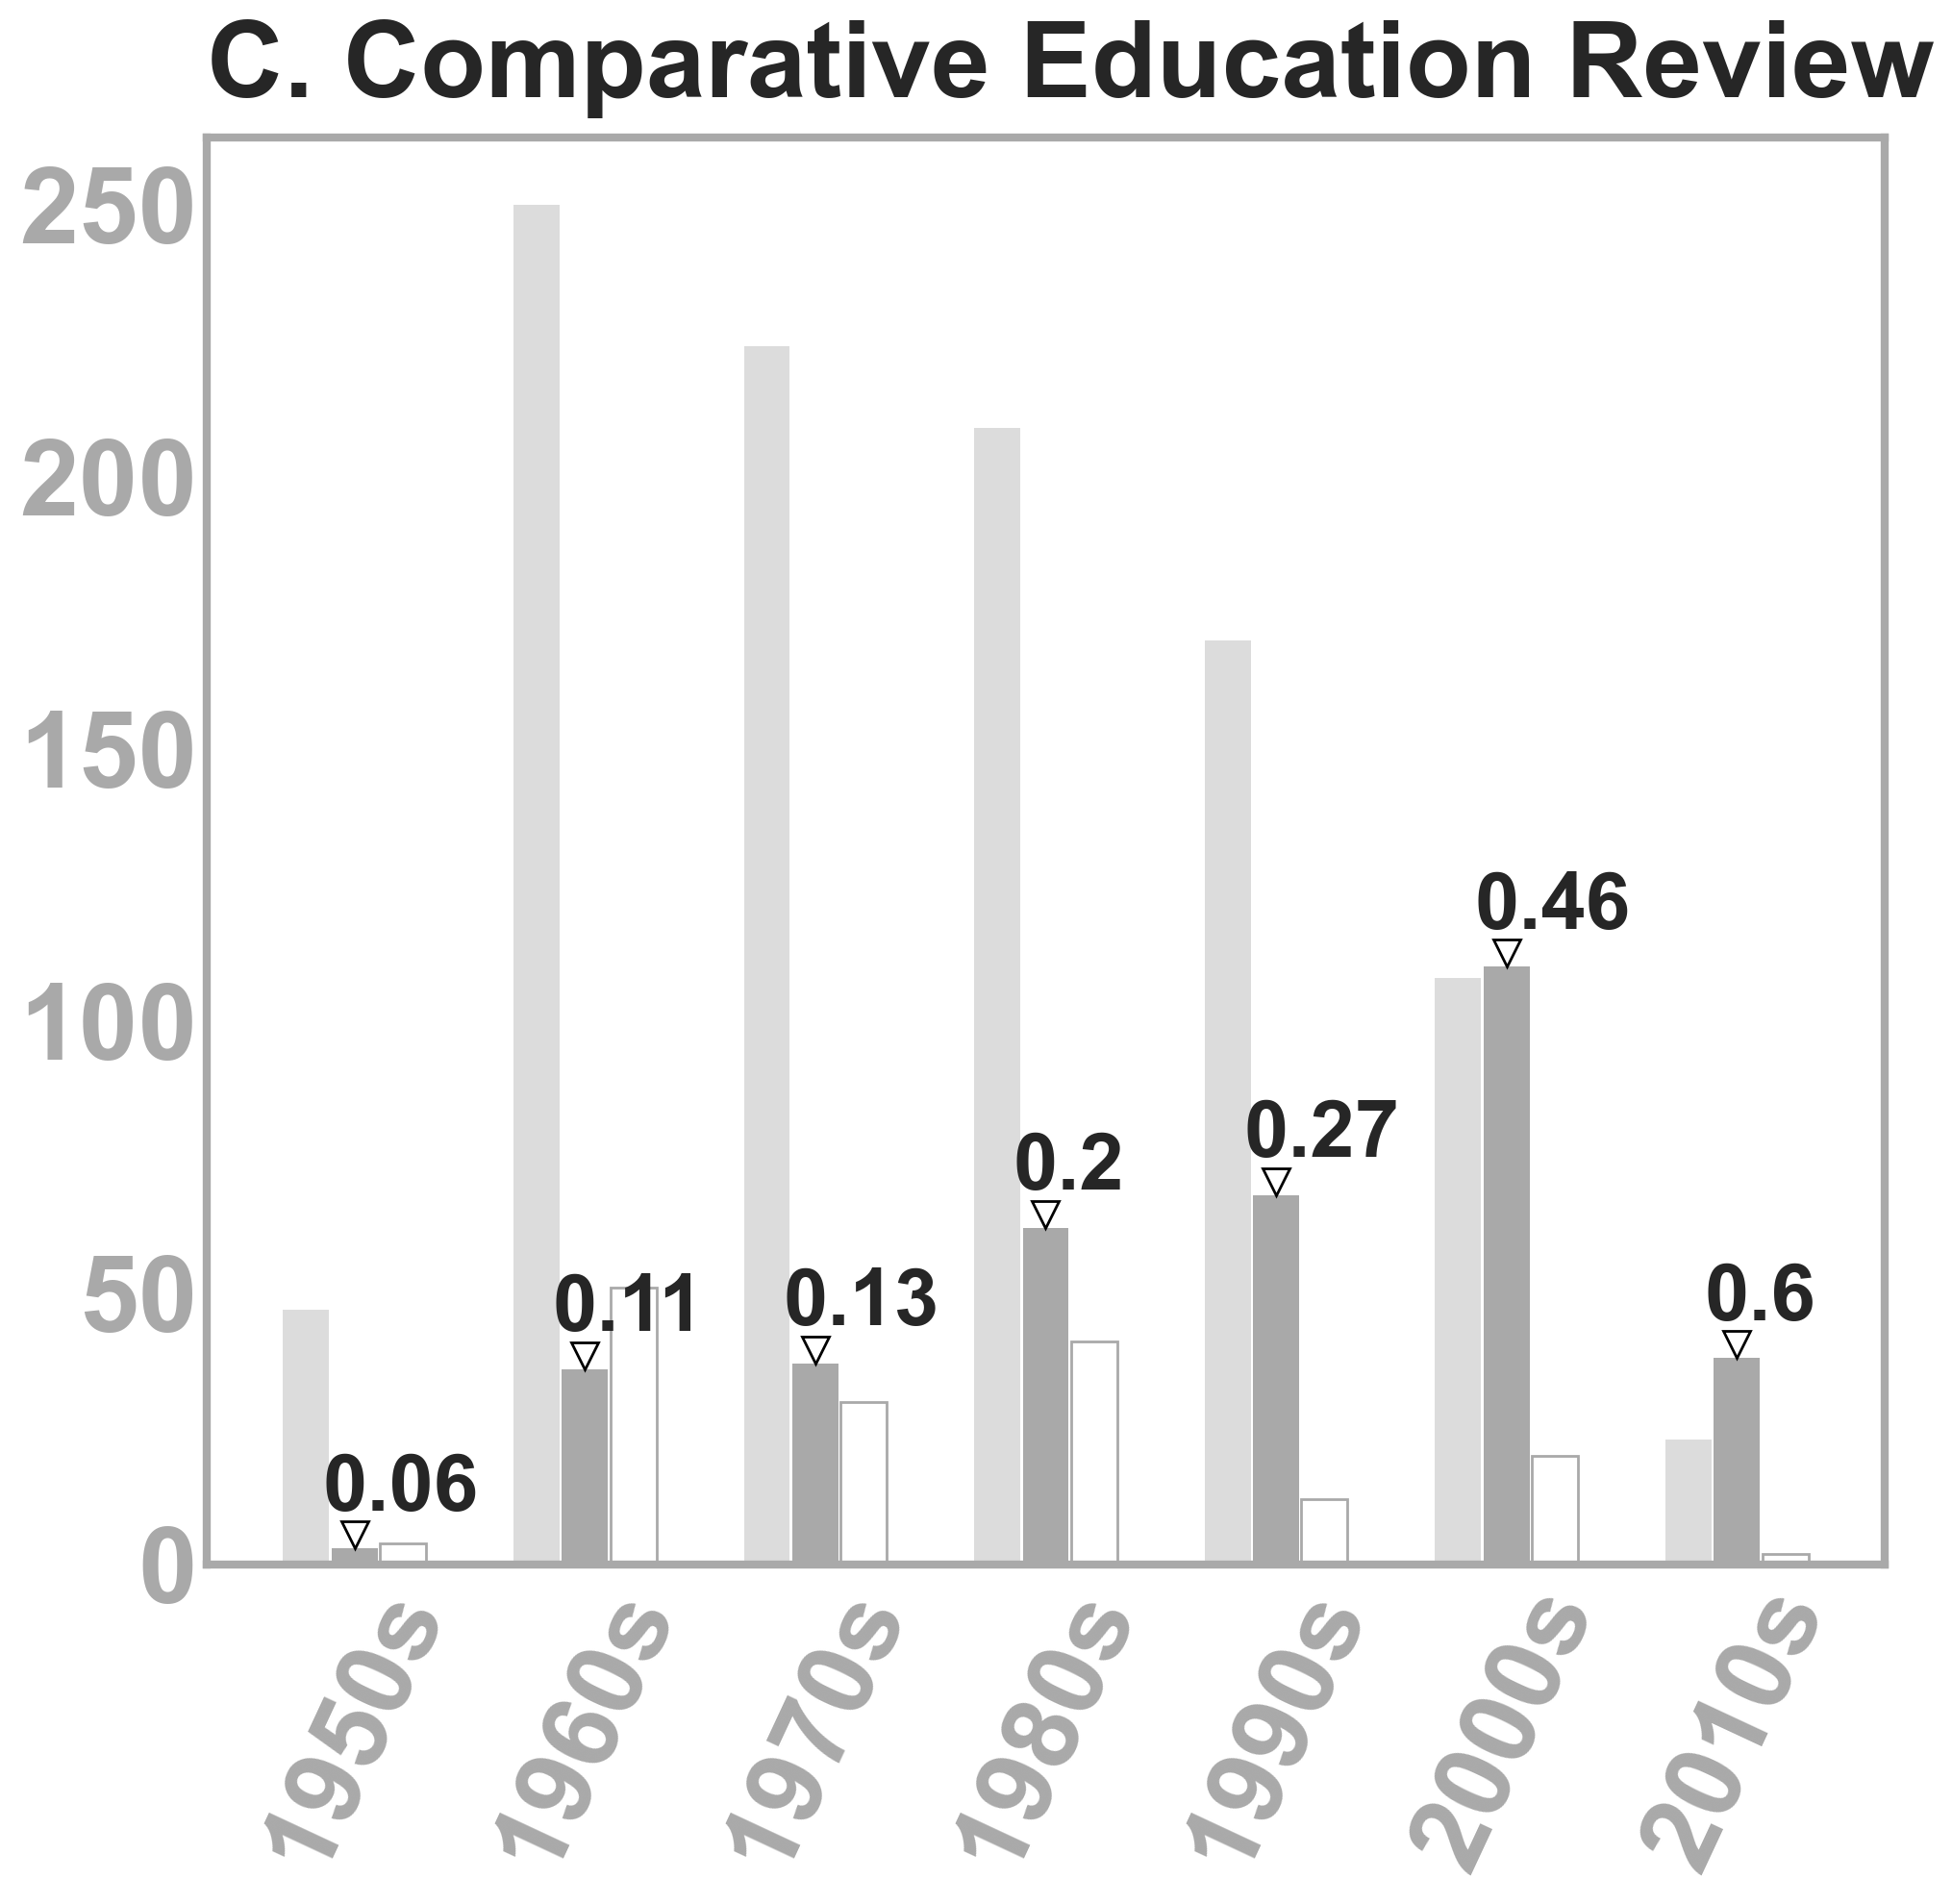

In [68]:
DF = df[df["journal"] == "Comparative Education Review"]

title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 40

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": 18}

decades = sorted(DF["decade"].unique())
man = DF.groupby("decade")["man"].sum().sort_index()
woman = DF.groupby("decade")["woman"].sum().sort_index()
unknown = DF.groupby("decade")["unknown"].sum().sort_index()

x = np.arange(len(decades))
width = 0.2

ax1.plot(
    decades,
    woman + 2.5,
    "-v",
    color="black",
    linewidth=0,
    label="prp. women first authors",
    markersize=10,
    markerfacecolor="none",
)

ax1.bar(x - width - 0.01, 
        man, 
        width, 
        label="man", 
        color="gainsboro",
)

ax1.bar(x, 
        woman, 
        width, 
        label="woman", 
        color="darkgrey"
)

ax1.bar(
    x + width + 0.01,
    unknown,
    width,
    label="unknown",
    color="white",
    edgecolor="darkgrey",
)

prop_woman = list(
    DF.groupby("decade")["woman"].sum().sort_index()
    / DF["decade"].value_counts().sort_index()
)

for i, pct in enumerate(prop_woman):
    ax1.annotate(f"{round(pct,2)}", 
                 (x[i] - 0.14, woman[i] + 7), 
                 size=30, 
                 weight="bold")

# ax1.set_ylabel(
#     "N First\nAuthors", 
#     rotation=0, 
#     labelpad=70, 
#     size=font_size, 
#     fontweight="bold"
# )
# ax1.set_yticks(range(0,22000,3000))
# ax1.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.13),
#     fancybox=True,
#     shadow=False,
#     ncol=1,
#     frameon=0,
#     prop=legend_properties,
# )

ax1.set_title(
    "C. Comparative Education Review",
    loc="left",
    size=font_size,
    fontweight="bold",
    pad=15,
)
fig.tight_layout()
plt.show()

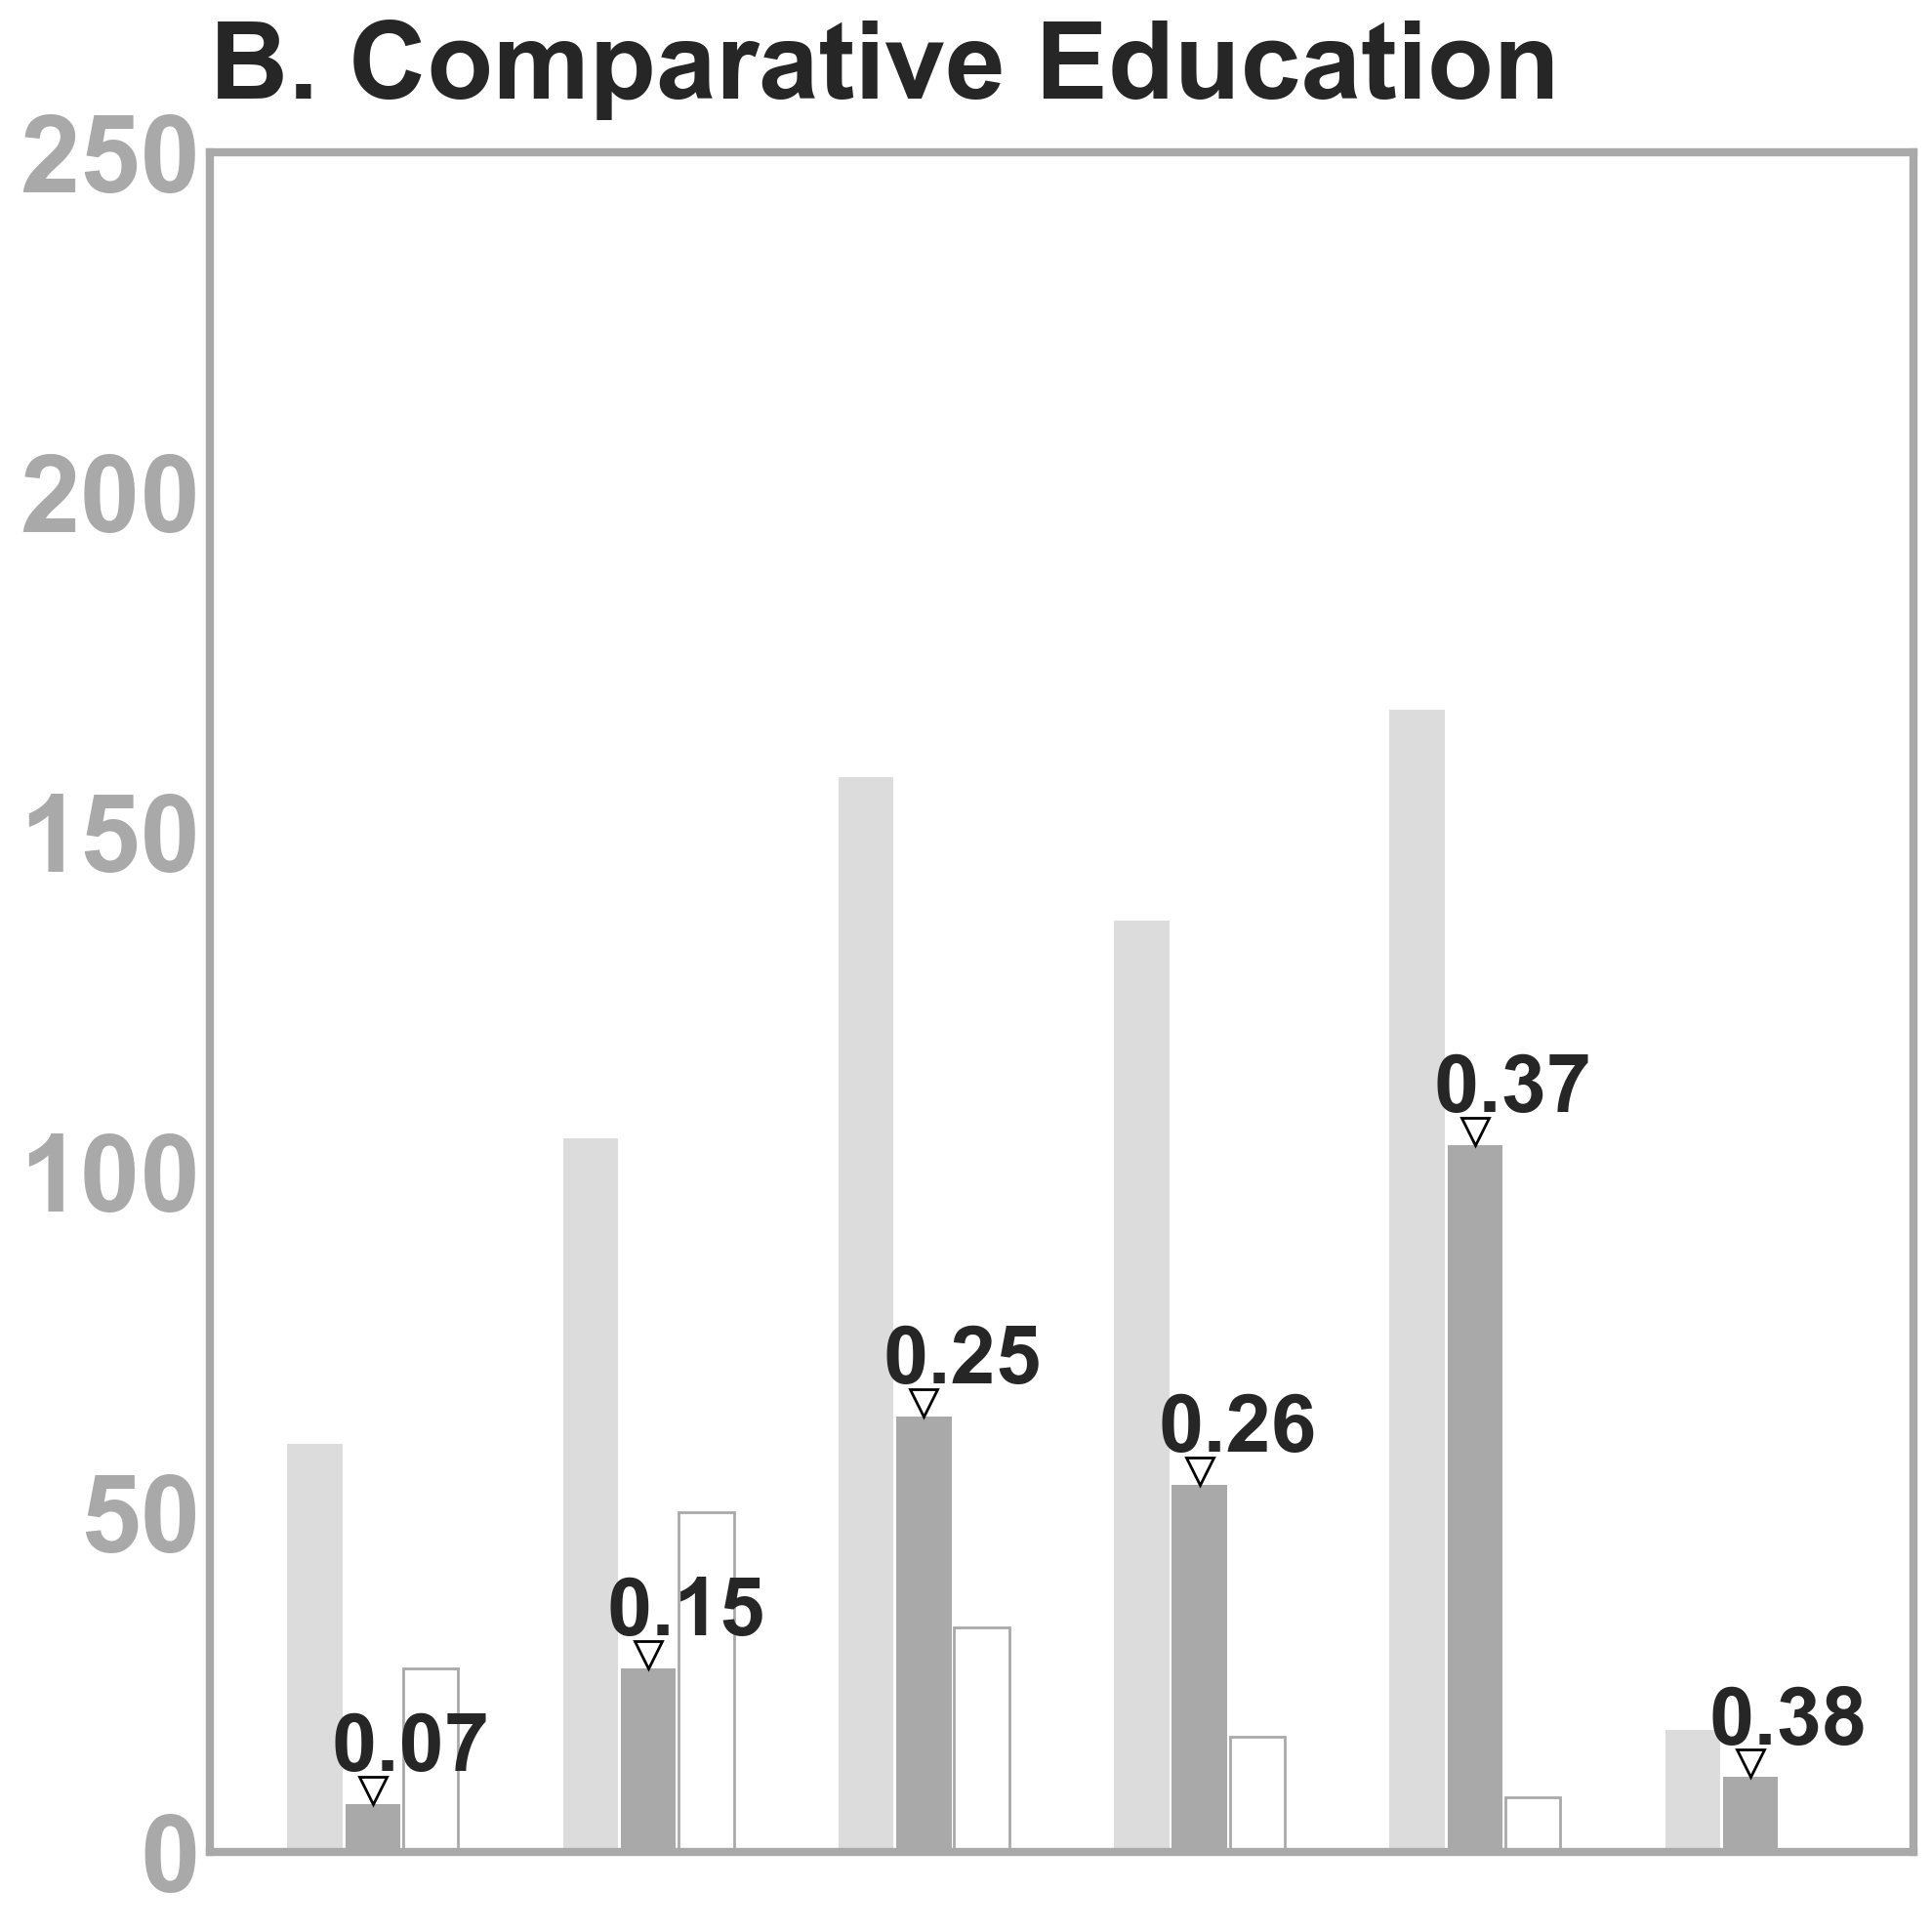

In [134]:
DF = df[df["journal"] == "Comparative Education"]

title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 40

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=0, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": 18}

decades = sorted(DF["decade"].unique())
# man = DF.groupby("decade")["man"].sum().sort_index()
# woman = DF.groupby("decade")["woman"].sum().sort_index()
# unknown = DF.groupby("decade")["unknown"].sum().sort_index()
man = DF.groupby("decade")["man"].sum()
woman = DF.groupby("decade")["woman"].sum()
unknown = DF.groupby("decade")["unknown"].sum()

x = np.arange(len(decades))
width = 0.2

ax1.plot(
    decades,
    woman + 2,
    "-v",
    color="black",
    linewidth=0,
    label="prp. women first authors",
    markersize=10,
    markerfacecolor="none",
)
ax1.bar(x - width - 0.01, man, width, label="man", color="gainsboro")
ax1.bar(x, woman, width, label="woman", color="darkgrey")
ax1.bar(
    x + width + 0.01,
    unknown,
    width,
    label="unknown",
    color="white",
    edgecolor="darkgrey",
)

prop_woman = list(
    DF.groupby("decade")["woman"].sum().sort_index()
    / DF["decade"].value_counts().sort_index()
)

for i, pct in enumerate(prop_woman):
    ax1.annotate(f"{round(pct,2)}", (x[i] - 0.15, woman[i] + 5), size=30, weight="bold")

# ax1.set_ylabel(
#     "N First\nAuthors", rotation=0, labelpad=70, size=font_size, fontweight="bold"
# )

ax1.set_yticks(range(0, 251, 50))

# ax1.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.13),
#     fancybox=True,
#     shadow=False,
#     ncol=1,
#     frameon=0,
#     prop=legend_properties,
# )

ax1.set_title(
    "B. Comparative Education", loc="left", size=font_size, fontweight="bold", pad=20
)
fig.tight_layout()
plt.show()

## Gender Topic

In [33]:
mallet = pickle.load(open(ROOT + "models/mallet80model.pkl", "rb"))

In [34]:
topics = mallet.show_topics(formatted=False, num_topics=80, num_words=50)

In [35]:
colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [36]:
topics[75][1][:10]

[('women', 0.12521638974375138),
 ('gender', 0.05508435816909182),
 ('male', 0.05405212813082085),
 ('femal', 0.0522929176274948),
 ('girl', 0.0473222486513005),
 ('sex', 0.041233359016322114),
 ('men', 0.03921720442779751),
 ('boi', 0.03469704408098467),
 ('sexual', 0.022434987151082778),
 ('male_femal', 0.011846150103993836)]

In [37]:
def grey_color_func(
    word, font_size, position, orientation, random_state=None, **kwargs
):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 0)

In [38]:
cloud = WordCloud(
    stopwords=None,
    background_color="white",
    width=2000,
    height=2000,
    max_words=100,
    color_func=grey_color_func,
    prefer_horizontal=1,
    max_font_size=500,
)

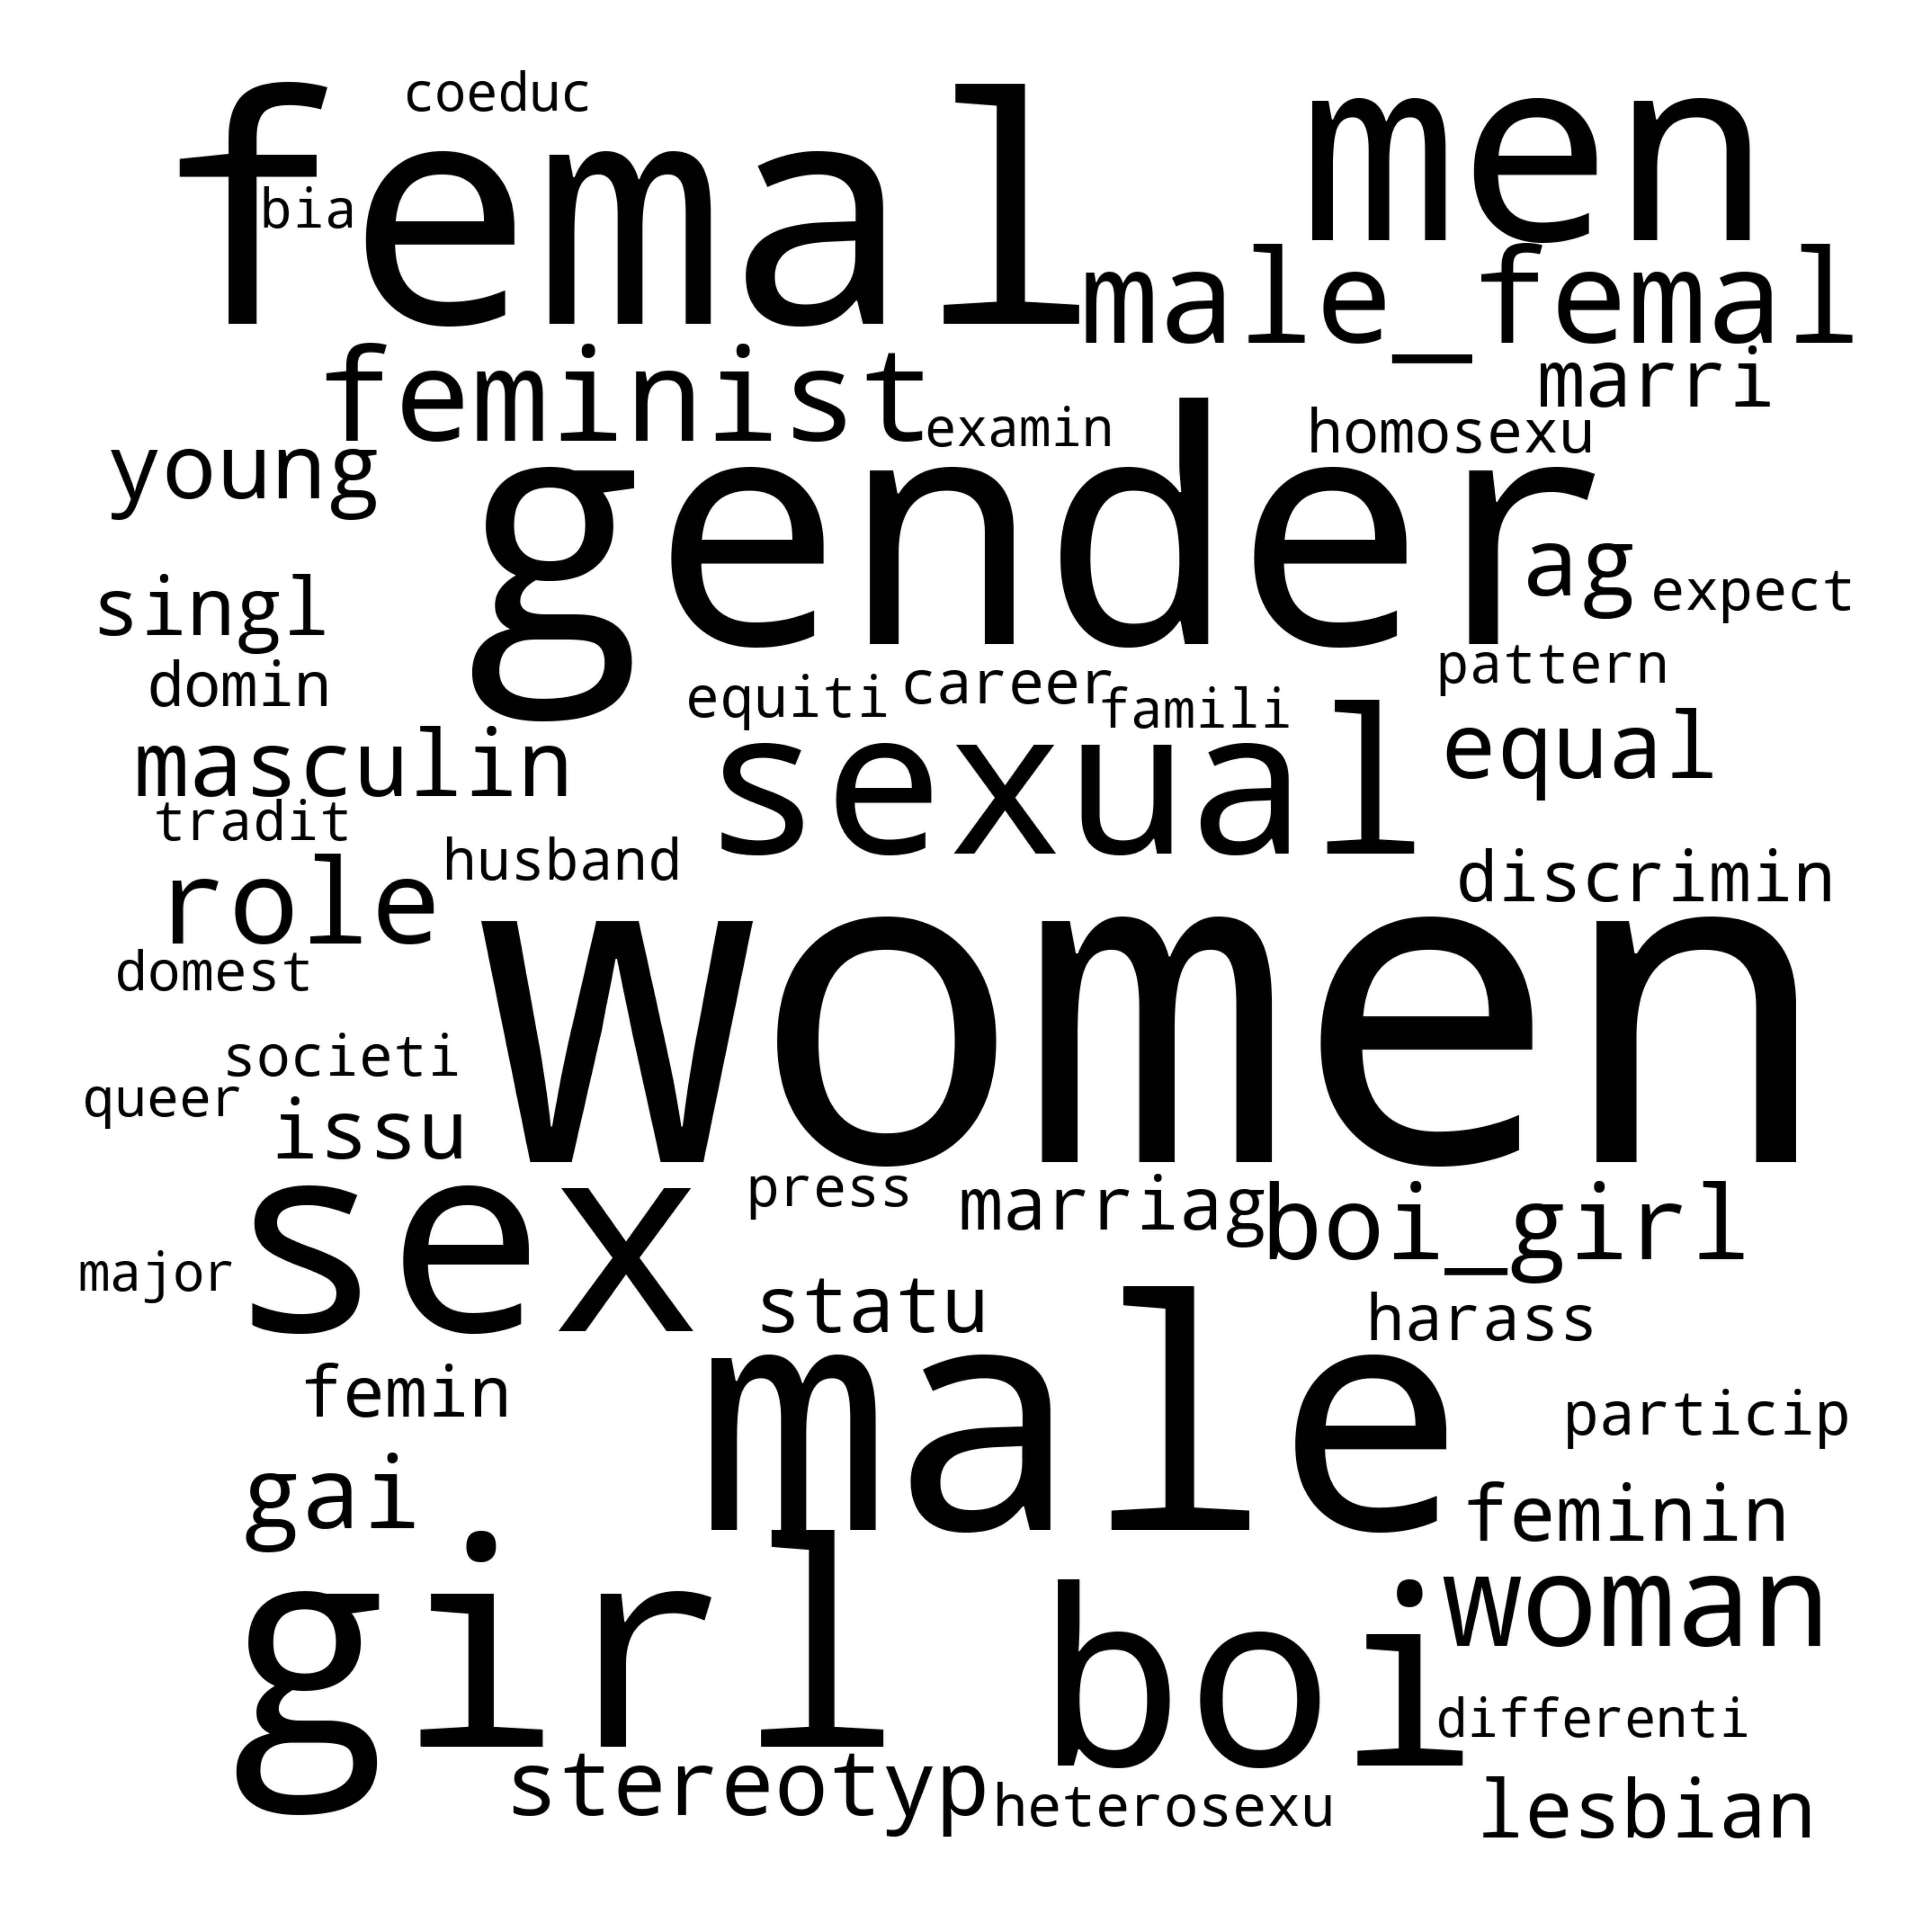

In [39]:
topic_words = dict(topics[75][1])
cloud.generate_from_frequencies(topic_words)
plt.figure(figsize=(3, 3), dpi=800)
plt.gca().imshow(cloud)
plt.gca().axis("off")
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()

## Trends in Gender Topic

In [136]:
df["gender_article"] = np.where((df["std_gender_topic"] > 0), 1, 0)

In [41]:
df["gender_article"].value_counts()

0    204522
1     38538
Name: gender_article, dtype: int64

In [42]:
# df = df.sort_values("year")
# df = df[df["year"] < 2013]

In [137]:
def rolling_mean(all_years, n_years):
    means = []
    for i, year in enumerate(all_years):
        if i <= n_years:
            means.append(None)
        else:
            means.append(np.mean(all_years[i - n_years + 1 : i + 1]))
    return means

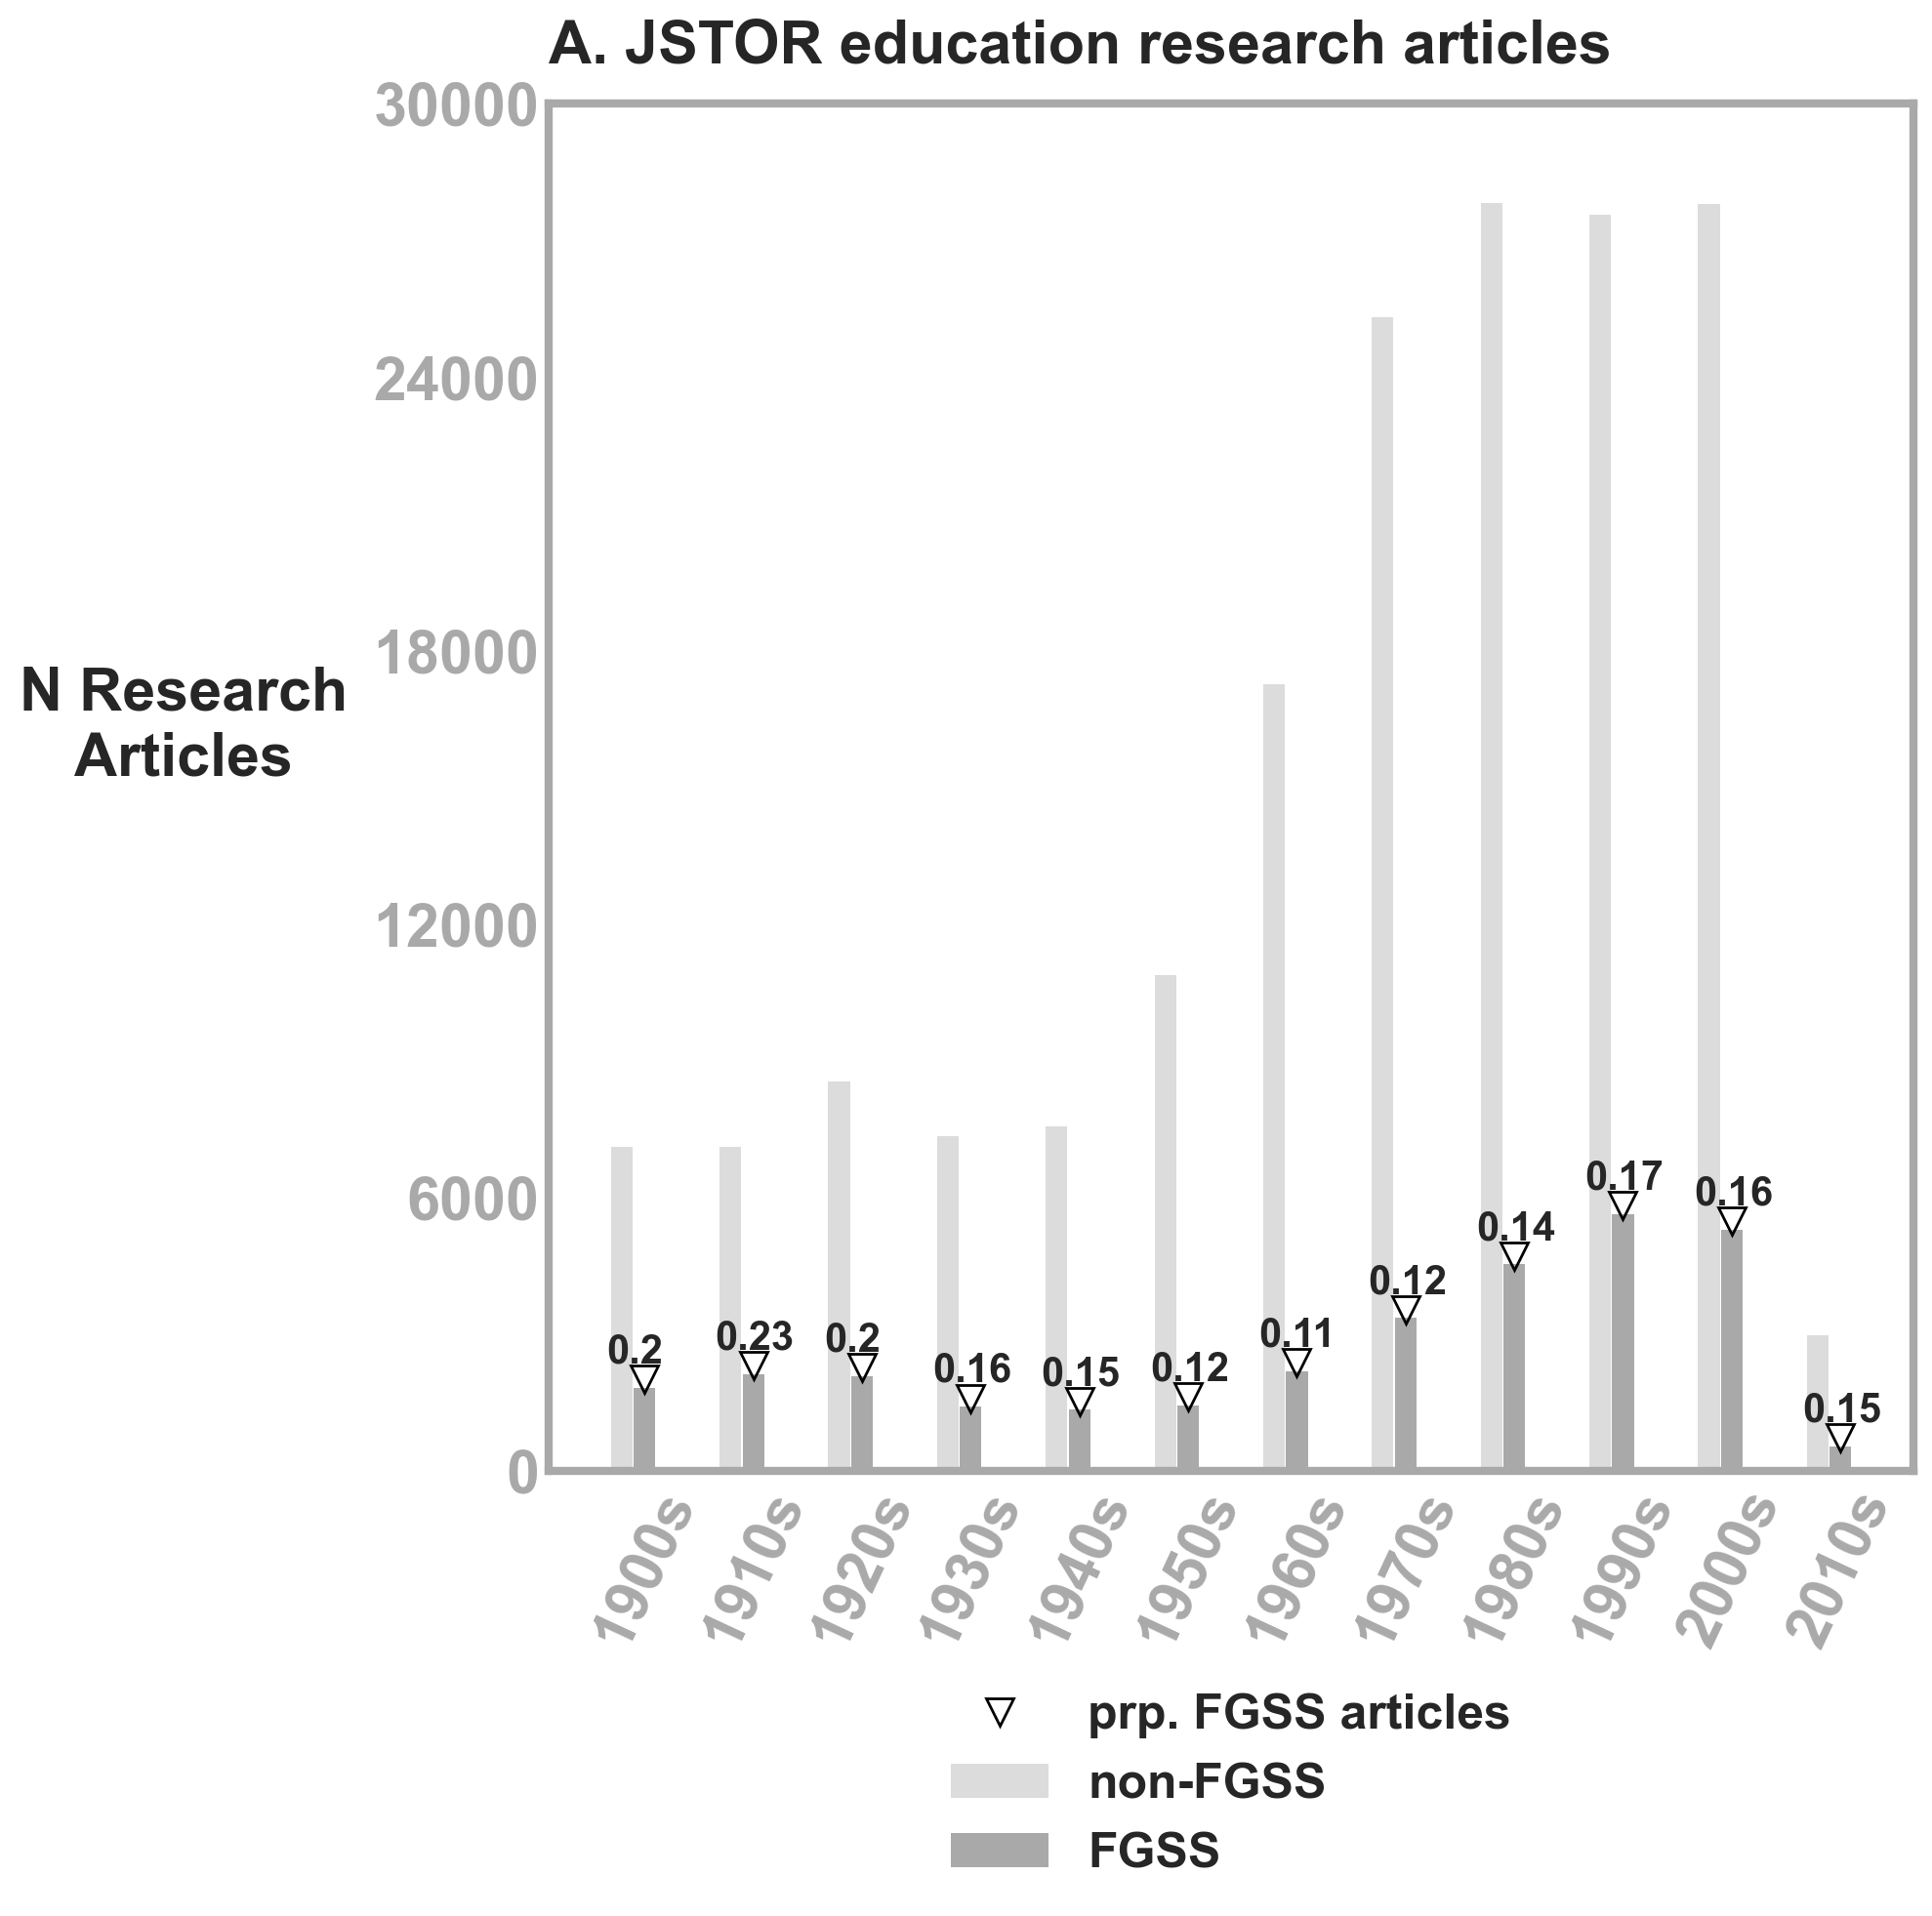

In [138]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 22

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": 18}

# decades = sorted(df["decade"].unique())
# man = df.groupby("decade")["man"].sum().sort_index()
# woman = df.groupby("decade")["woman"].sum().sort_index()
# unknown = df.groupby("decade")["unknown"].sum().sort_index()

decades = sorted(df["decade"].unique())
non = df.groupby("decade")['decade'].count().sort_index() - df.groupby("decade")["gender_article"].sum().sort_index()
gender = df.groupby("decade")["gender_article"].sum().sort_index()


x = np.arange(len(decades))
width = 0.2

ax1.plot(
    decades,
    gender + 185,
    "-v",
    color="black",
    linewidth=0,
    label="prp. FGSS articles",
    markersize=10,
    markerfacecolor="none",
)

ax1.bar(x - width - 0.01, 
        non, 
        width, 
        label="non-FGSS", 
        color="gainsboro")

ax1.bar(x, 
        gender, 
        width, 
        label="FGSS", 
        color="darkgrey")


prop_gender = list(
    df.groupby("decade")["gender_article"].sum().sort_index()
    / df["decade"].value_counts().sort_index()
)

for i, pct in enumerate(prop_gender):
    ax1.annotate(
        f"{round(pct,2)}", 
        (x[i] - 0.35, gender[i] + 550), 
        size=15, 
        weight="bold"
    )

ax1.set_ylabel(
    "N Research\nArticles", 
    rotation=0, 
    labelpad=70, 
    size=font_size, 
    fontweight="bold"
)

ax1.set_yticks(range(0, 36000, 6000))
ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)

ax1.set_title("A. JSTOR education research articles", 
              loc="left", 
              size=font_size, 
              fontweight="bold", 
              pad=15)
fig.tight_layout()
plt.show()

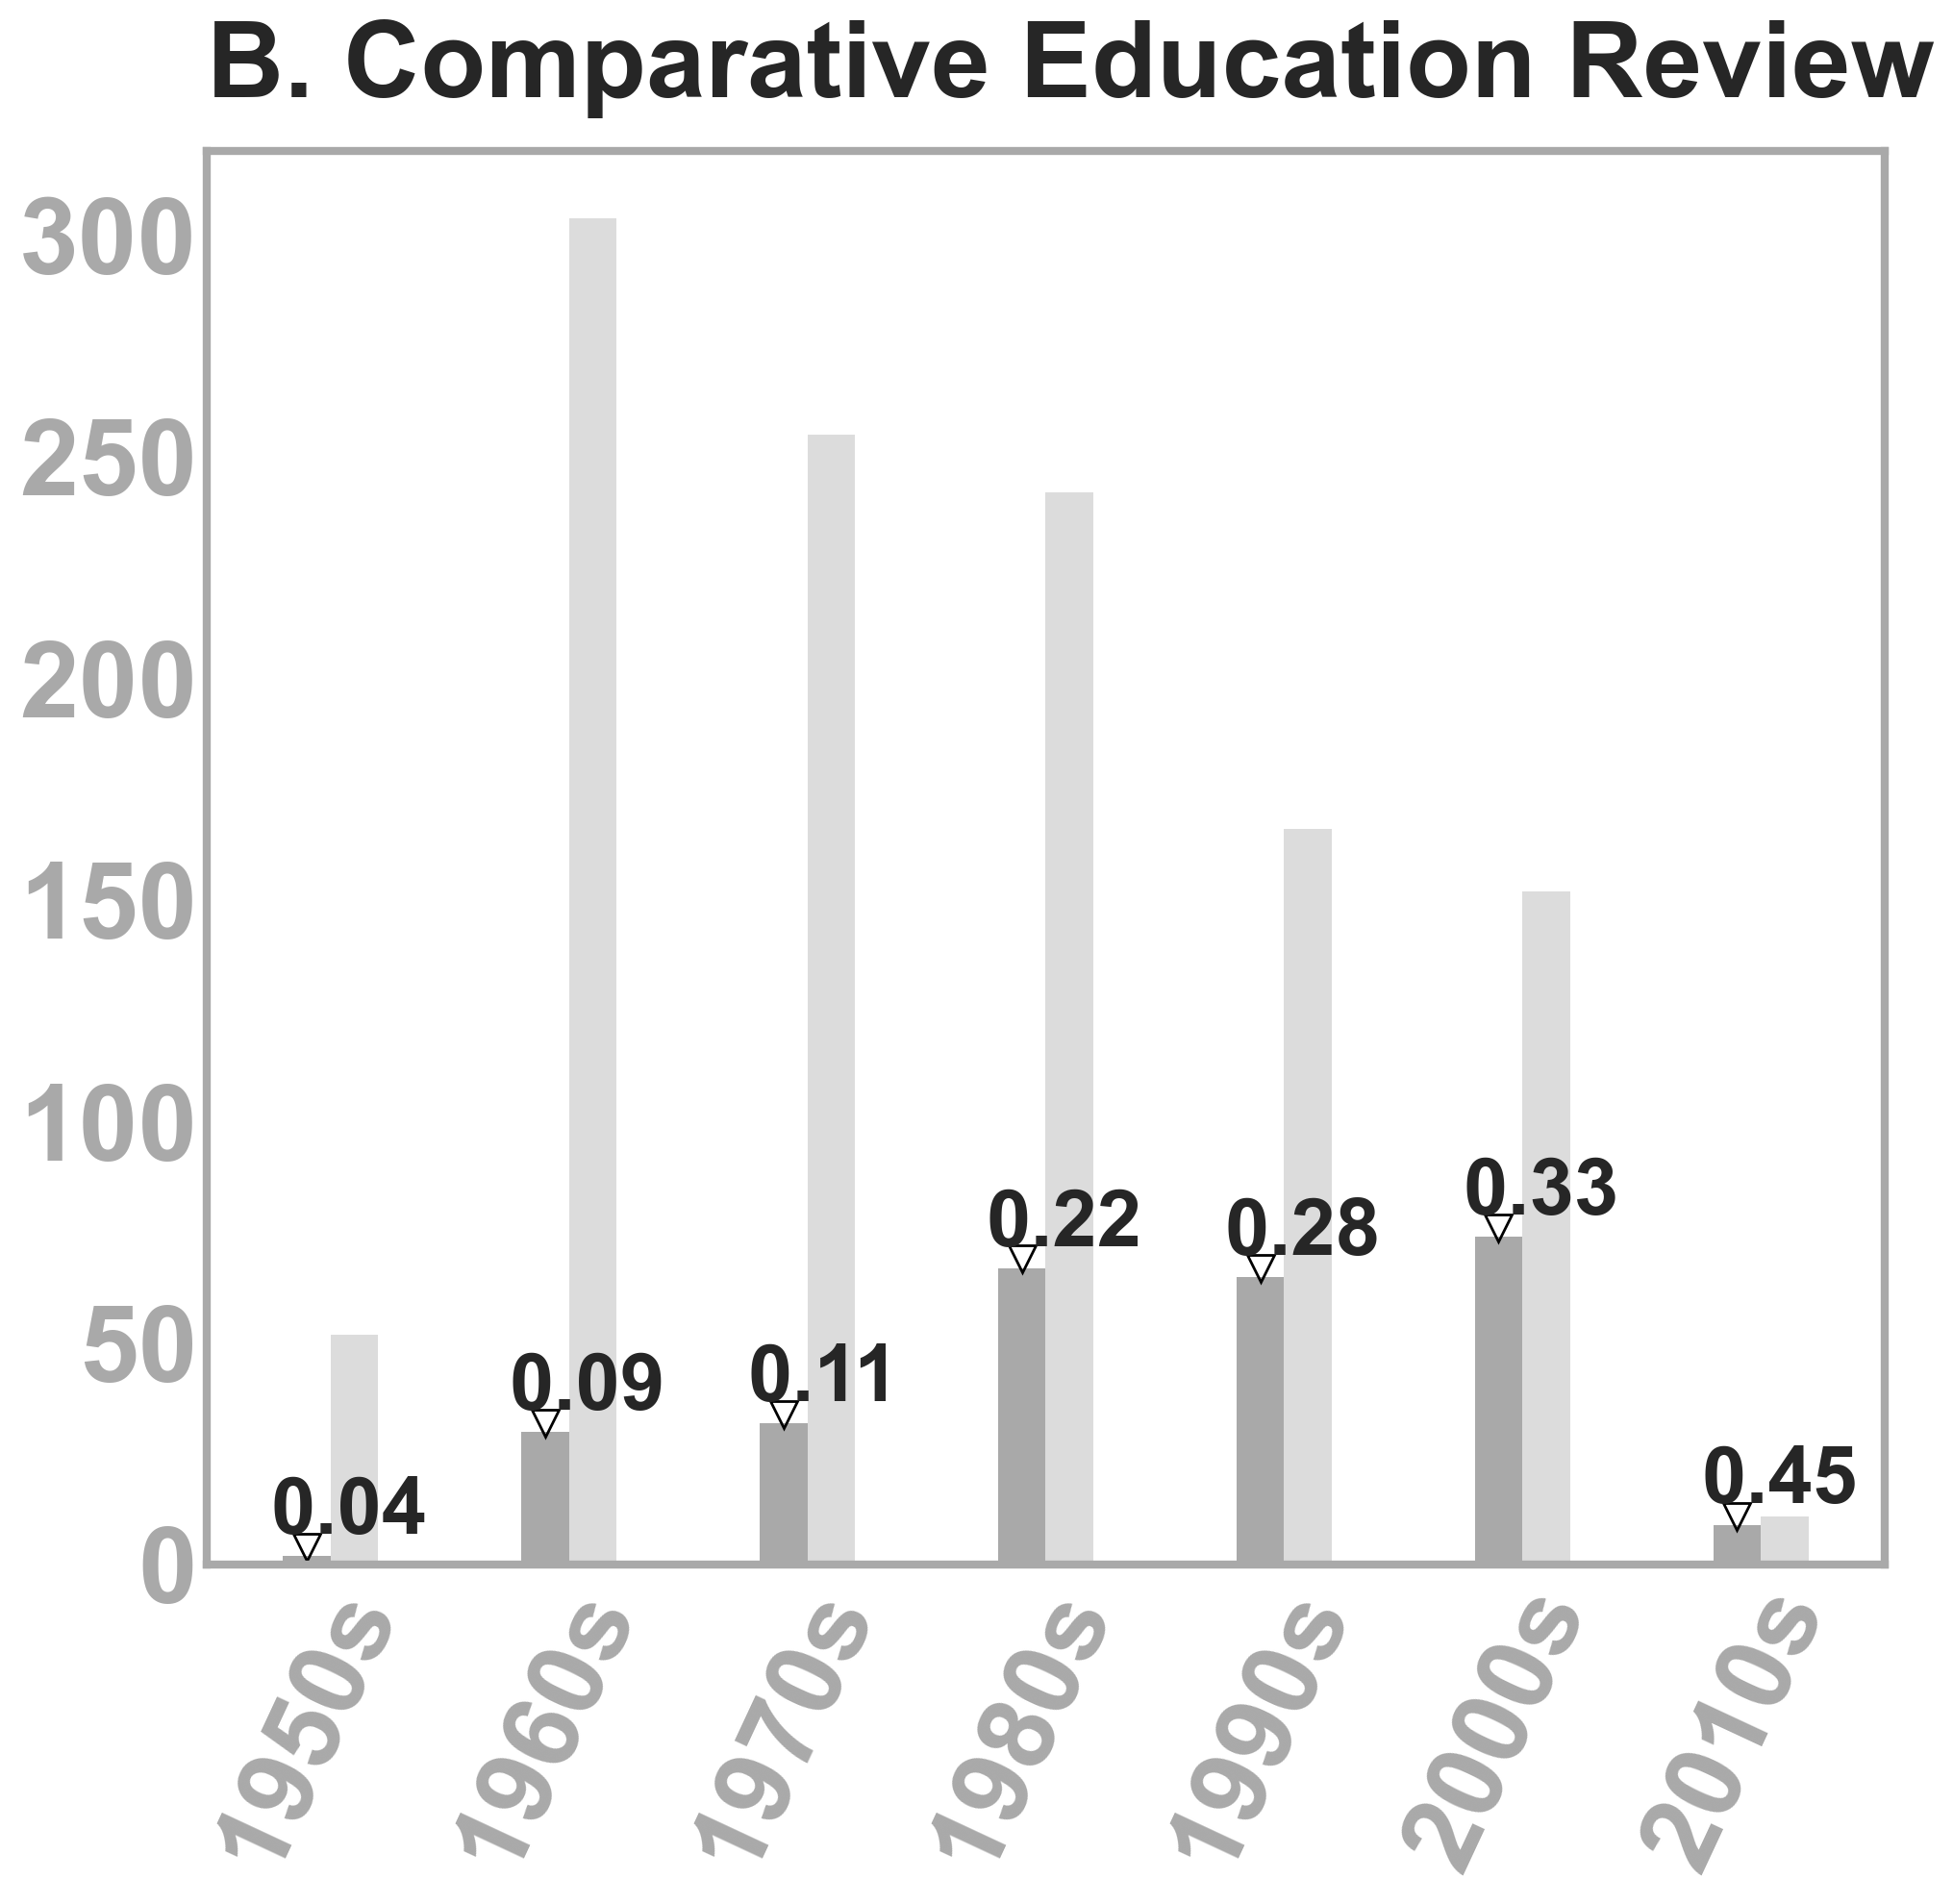

In [140]:
DF = df[df["journal"] == "Comparative Education Review"]

title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 40

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": 18}

decades = sorted(DF["decade"].unique())
# non = DF.groupby("decade")["gender_article"].sum().sort_index()
non = DF.groupby("decade")['decade'].count().sort_index() - DF.groupby("decade")["gender_article"].sum().sort_index()
gender = DF.groupby("decade")["gender_article"].sum().sort_index()


x = np.arange(len(decades))
width = 0.2

ax1.plot(
    decades,
    gender + 2,
    "-v",
    color="black",
    linewidth=0,
    label="prp. women first authors",
    markersize=10,
    markerfacecolor="none",
)
ax1.bar(x +width, non, width, label="non-FGSS", color="gainsboro")
ax1.bar(x, gender, width, label="FGSS", color="darkgrey")

prop_gender = list(
    DF.groupby("decade")["gender_article"].sum().sort_index()
    / DF["decade"].value_counts().sort_index()
)

for i, pct in enumerate(prop_gender):
    ax1.annotate(f"{round(pct,2)}", (x[i] - 0.15, gender[i] + 5), size=30, weight="bold")

# ax1.set_ylabel(
#     "N First\nAuthors", rotation=0, labelpad=70, size=font_size, fontweight="bold"
# )

ax1.set_yticks(range(0, 301, 50))

# ax1.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, -0.13),
#     fancybox=True,
#     shadow=False,
#     ncol=1,
#     frameon=0,
#     prop=legend_properties,
# )

ax1.set_title(
    "B. Comparative Education Review", loc="left", size=font_size, fontweight="bold", pad=20
)
fig.tight_layout()
plt.show()

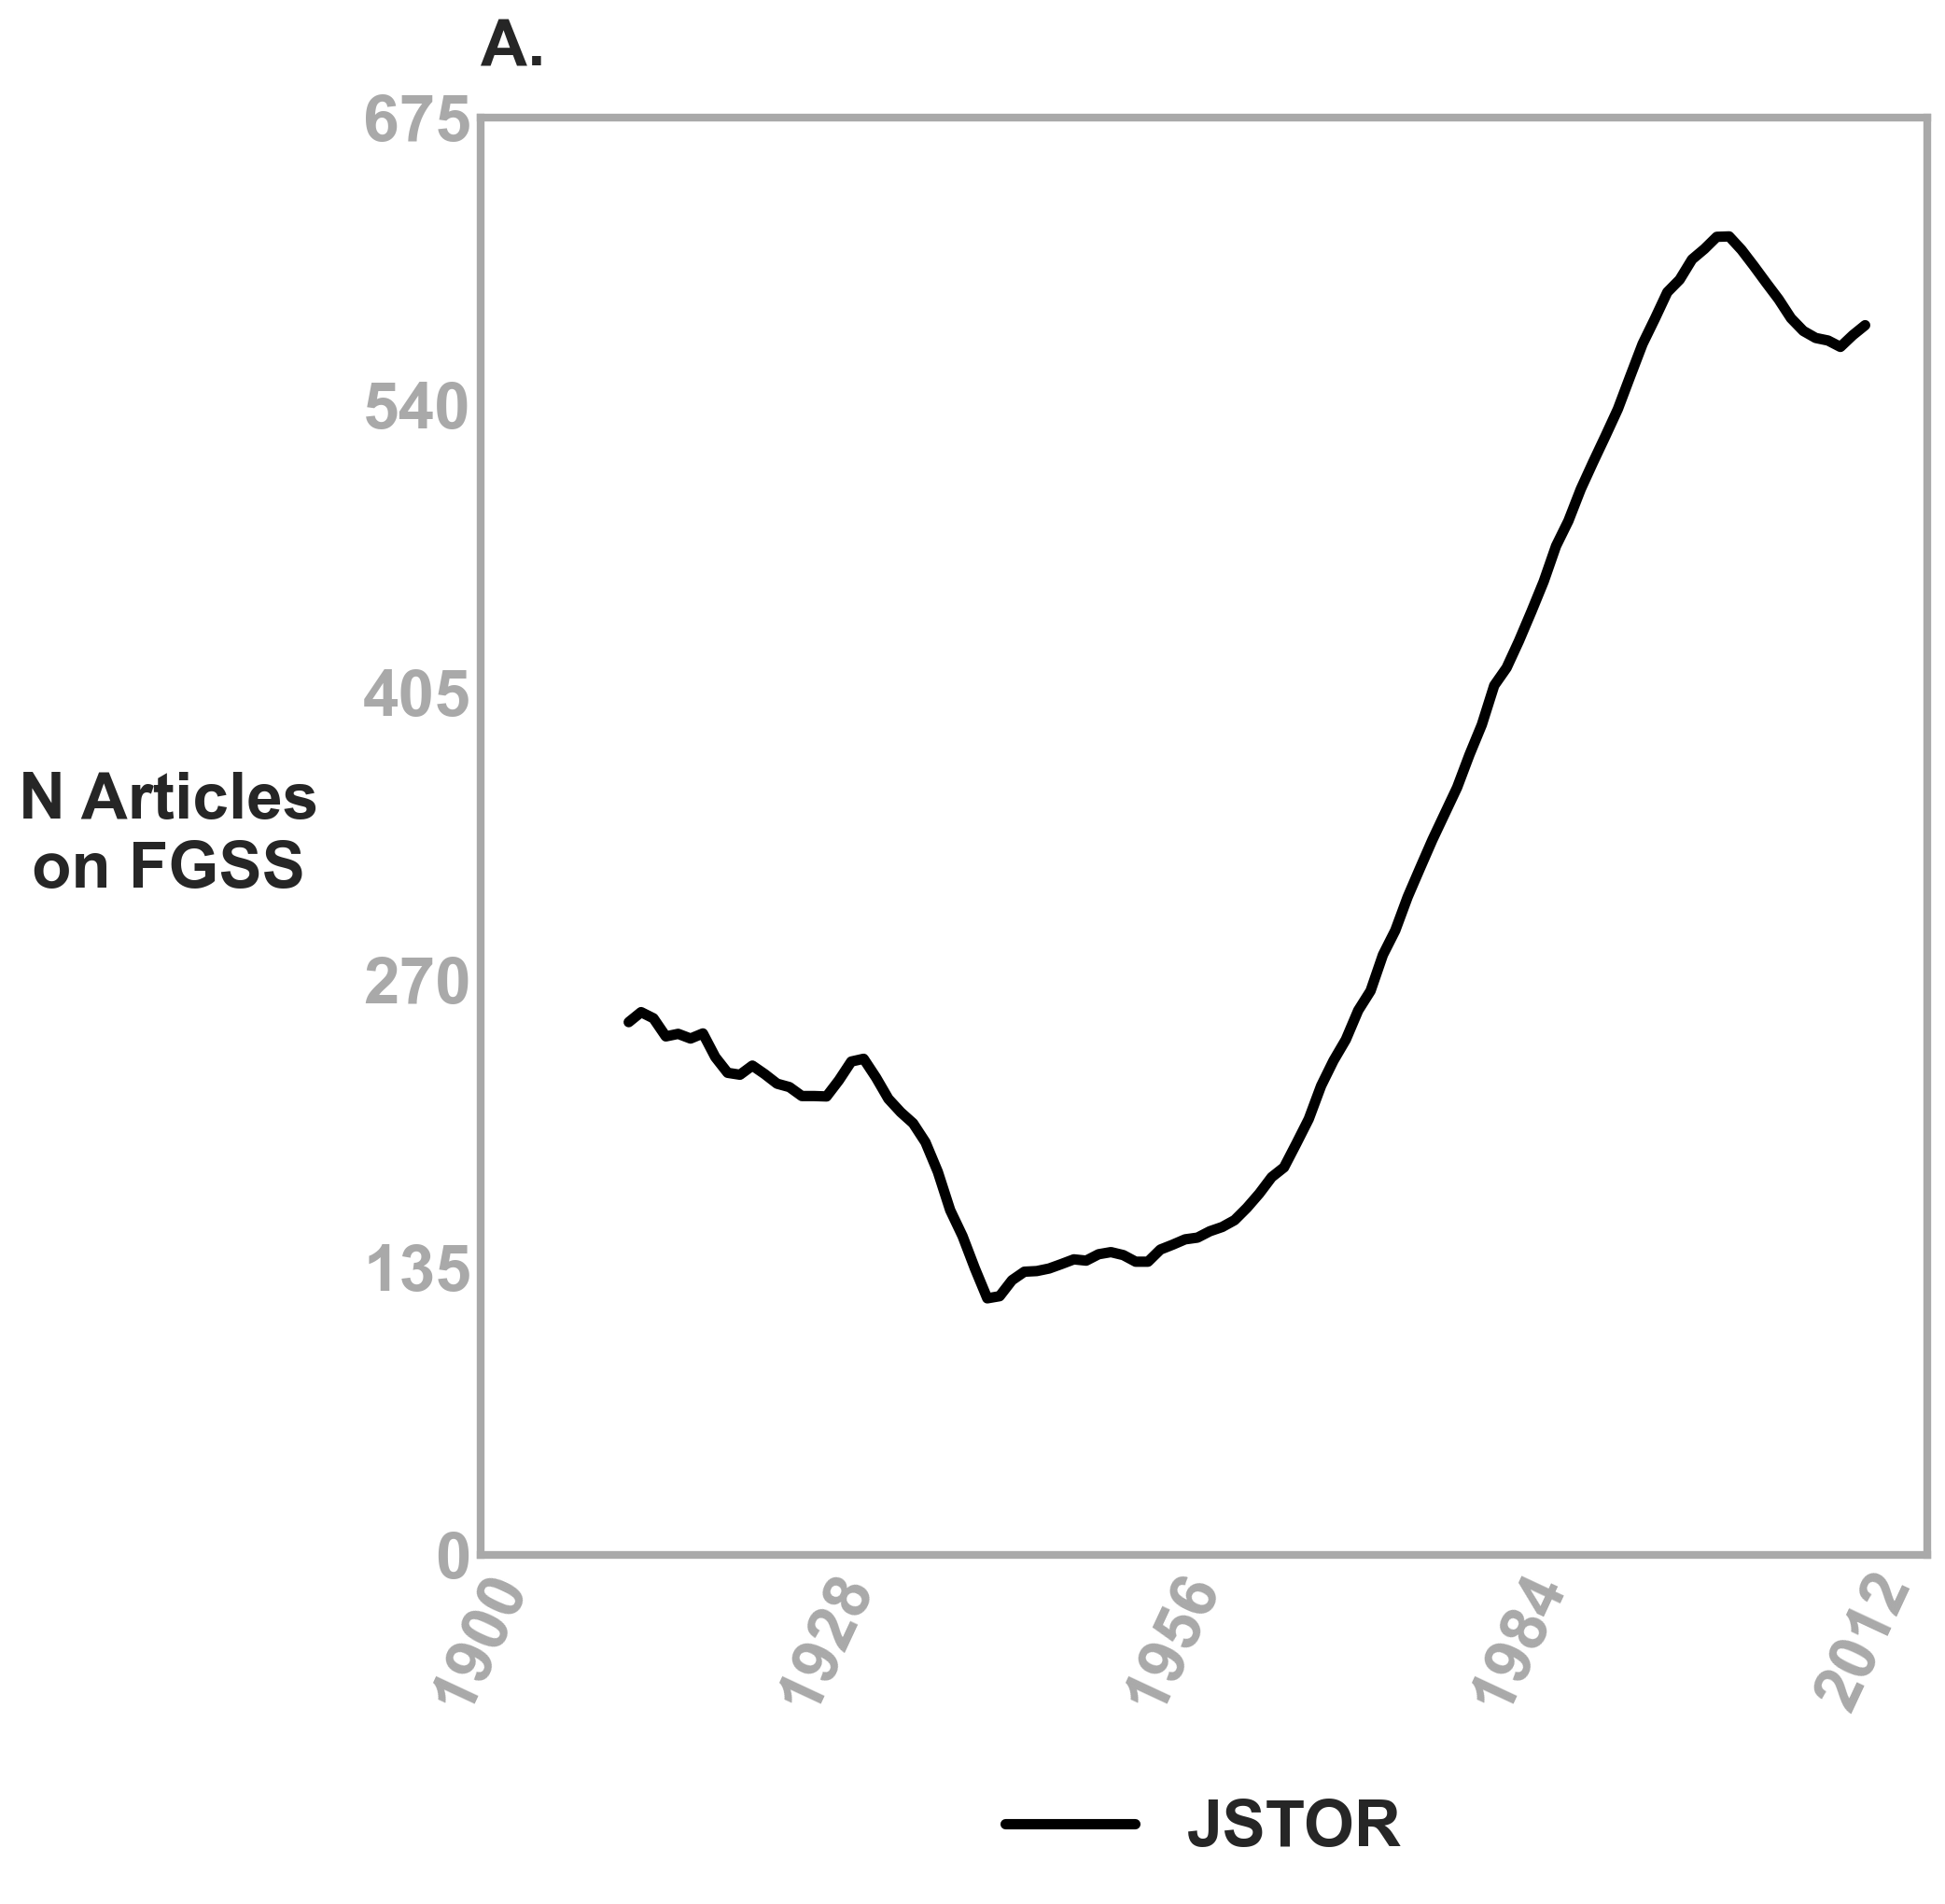

In [54]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": font_size}


nyears = 10
y = list(df.groupby("year")["gender_article"].sum().sort_index())
y1 = rolling_mean(y, nyears)

# y = list(df.groupby('year')['gender_article'].transform('sum'))
x = df["year"].unique()
plt.plot(x, y1, color="black", linewidth=4, label=f"JSTOR")
# plt.plot(x,y, '-o', color=edge_color, linewidth=0, label="Observed frequency");
plt.ylabel(
    "N Articles\non FGSS",
    rotation=0,
    labelpad=75,
    size=font_size,
    fontweight="bold",
    va="center",
)
plt.yticks(range(0, 676, 135))
plt.xticks(range(1900, 2013, 28))
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax1.set_title("A.", loc="left", size=font_size, fontweight="bold", pad=20)
plt.show()

In [60]:
cer = df[df["journal"] == "Comparative Education Review"]
ce = cer["year"].unique()
ce = pd.DataFrame(ce, columns=["year"])
ce = ce.merge(df[df["journal"] == "Comparative Education"], how="left", on="year")

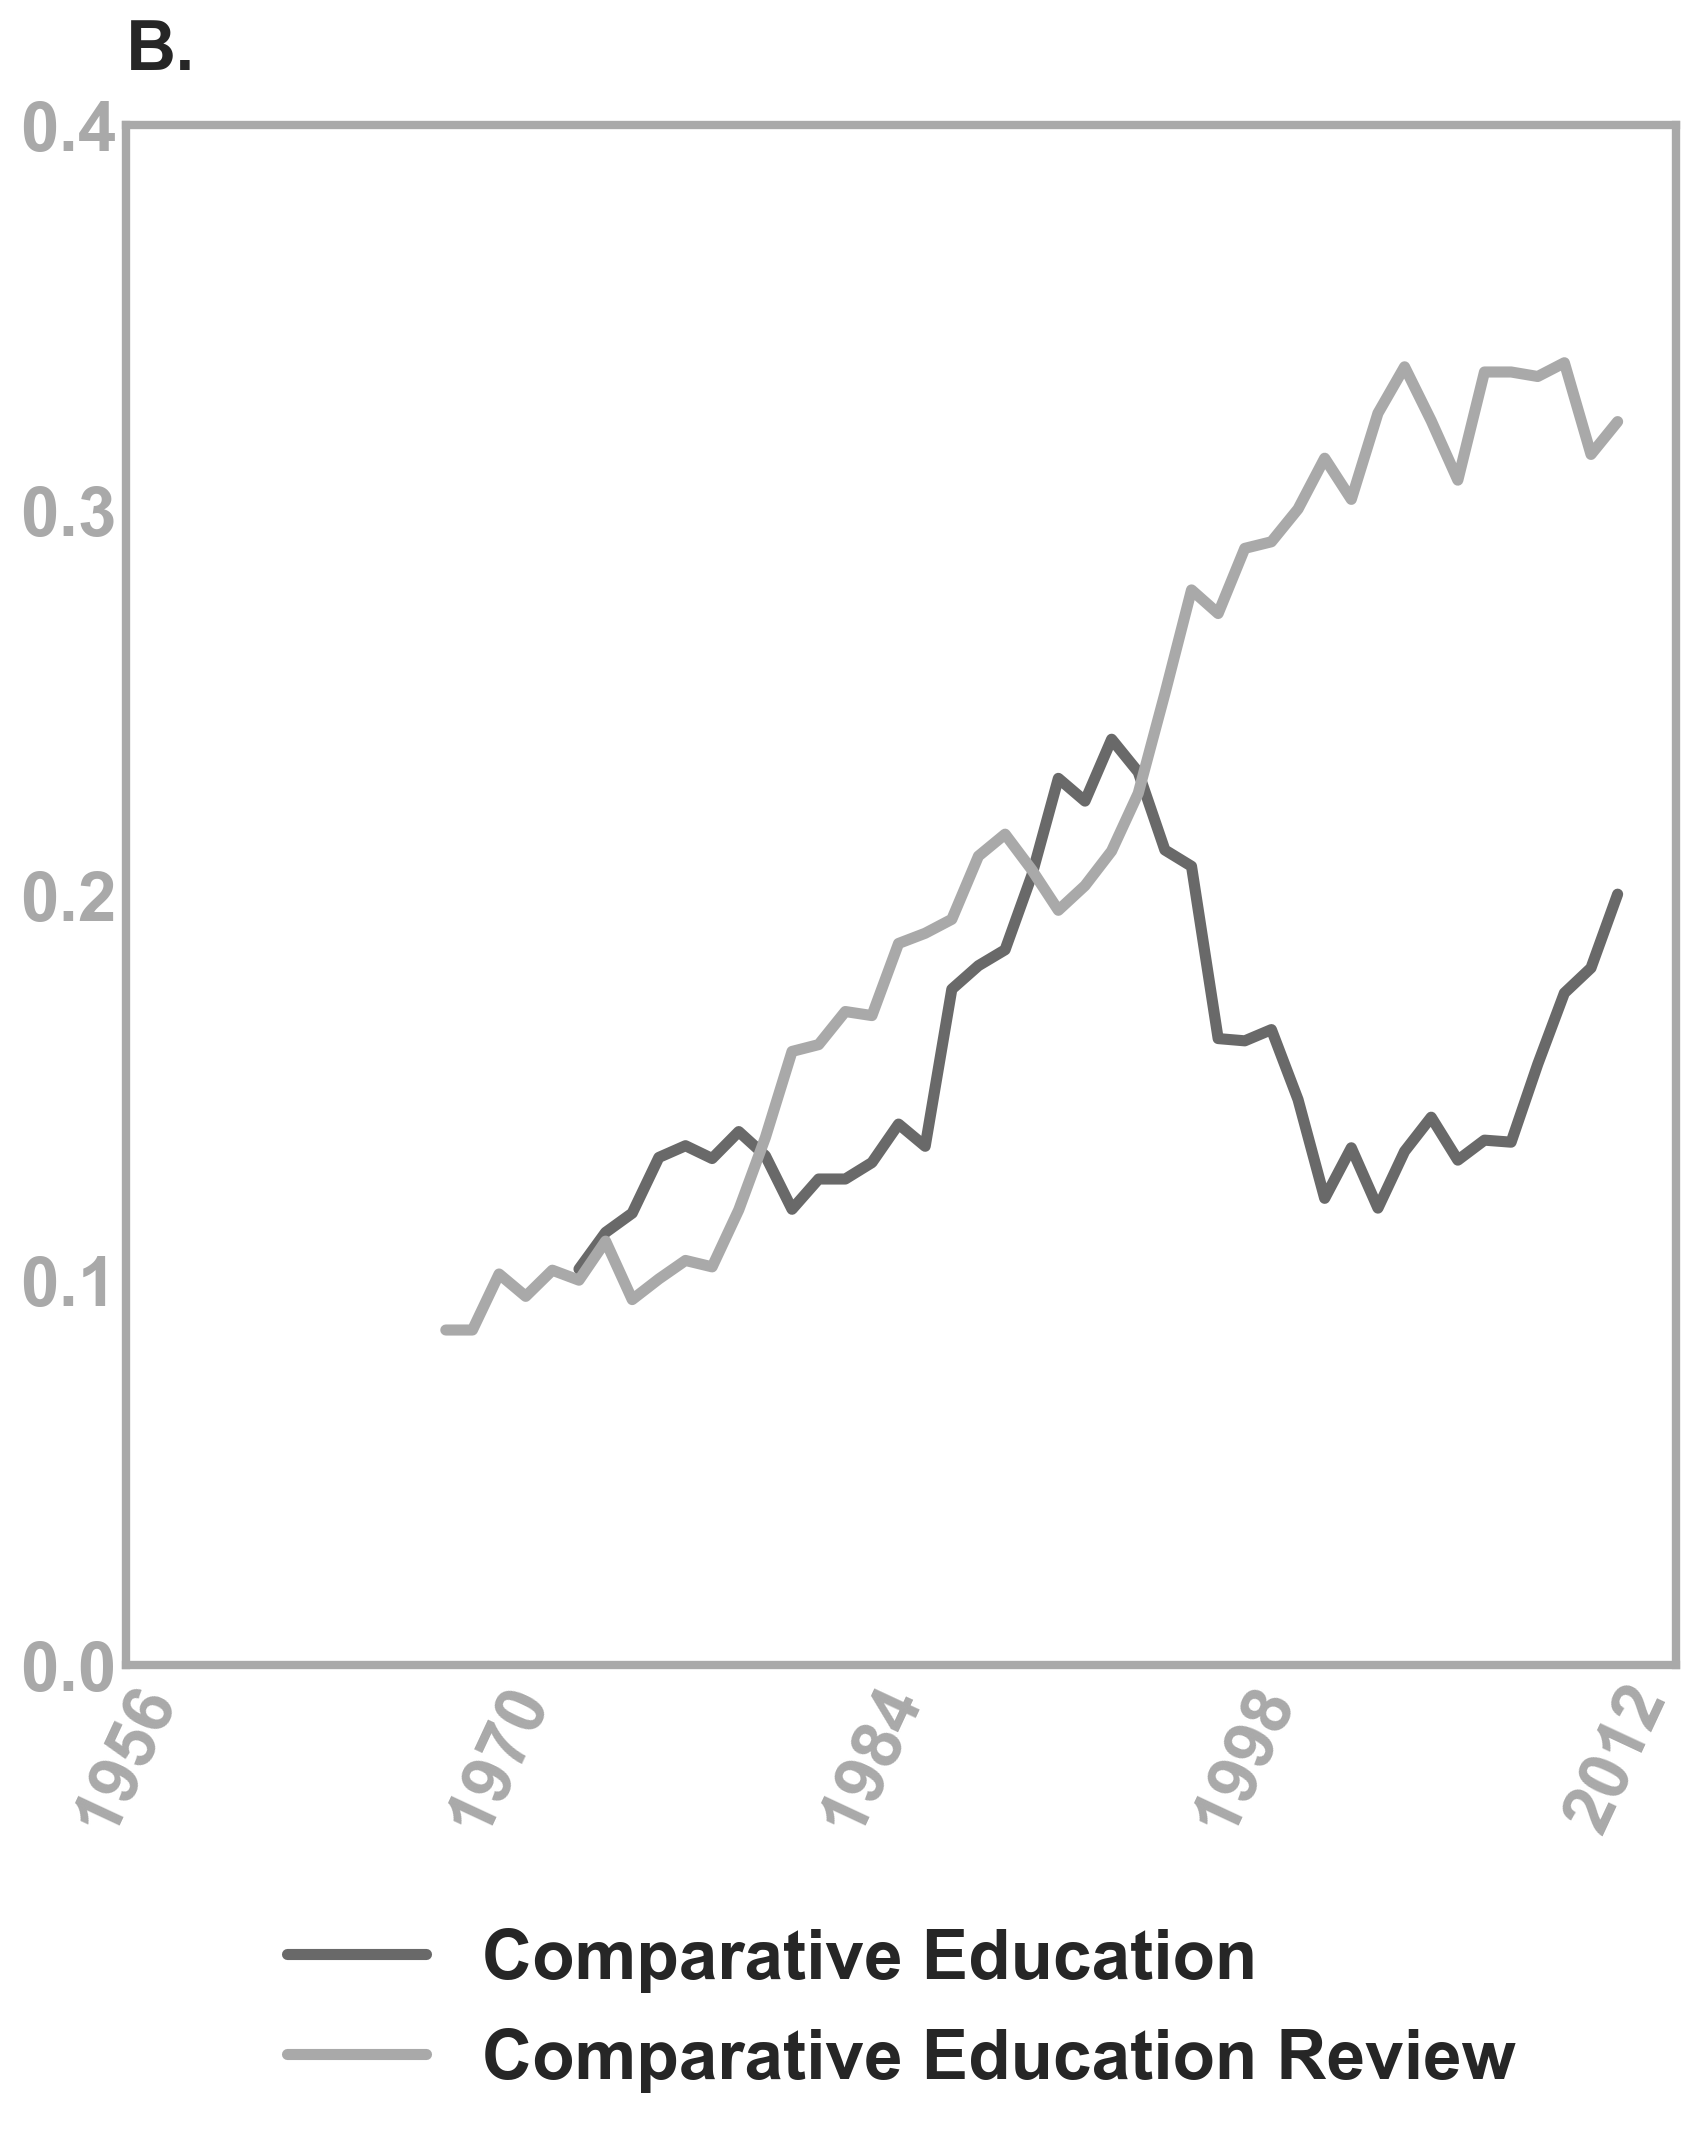

In [63]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": font_size}


# y = list(df.groupby('decade')['gender_article'].sum().sort_index())[:-1]
# x = sorted(df['decade'].unique())[:-1]
nyears = 10
y1a = list(ce.groupby("year")["gender_article"].sum()/ce.groupby("year")["gender_article"].count())
y1b = rolling_mean(y1a, nyears)

y2a = list(cer.groupby("year")["gender_article"].sum()/cer.groupby("year")["gender_article"].count())
y2b = rolling_mean(y2a, nyears)
x = ce["year"].unique()


plt.plot(
    x,
    y1b,
    # "-^",
    markerfacecolor="white",
    markersize=7,
    color=edge_color,
    label=f"Comparative Education",
    linewidth=4,
)
# plt.plot(x,y1a,
#          '-o',
#          color=edge_color,
#          label=f"(observed frequency)",
#          linewidth=0);
plt.plot(
    x,
    y2b,
    # "-o",
    markerfacecolor="white",
    markersize=5,
    color=tick_color,
    label=f"Comparative Education Review",
    linewidth=4,
)
# plt.plot(x,y2a,
#          '-o',
#          color=tick_color,
#          label=f"(observed frequency)",
#          linewidth=0);


# plt.ylabel('N Articles\non FGSS',
#            rotation=0,
#            labelpad=75,
#            size=font_size,
#            fontweight='bold',
#            va='center');
plt.yticks(np.arange(0, .41, .1))
plt.xticks(range(1956, 2013, 14))
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax1.set_title("B.", loc="left", size=font_size, fontweight="bold", pad=20)
plt.show()

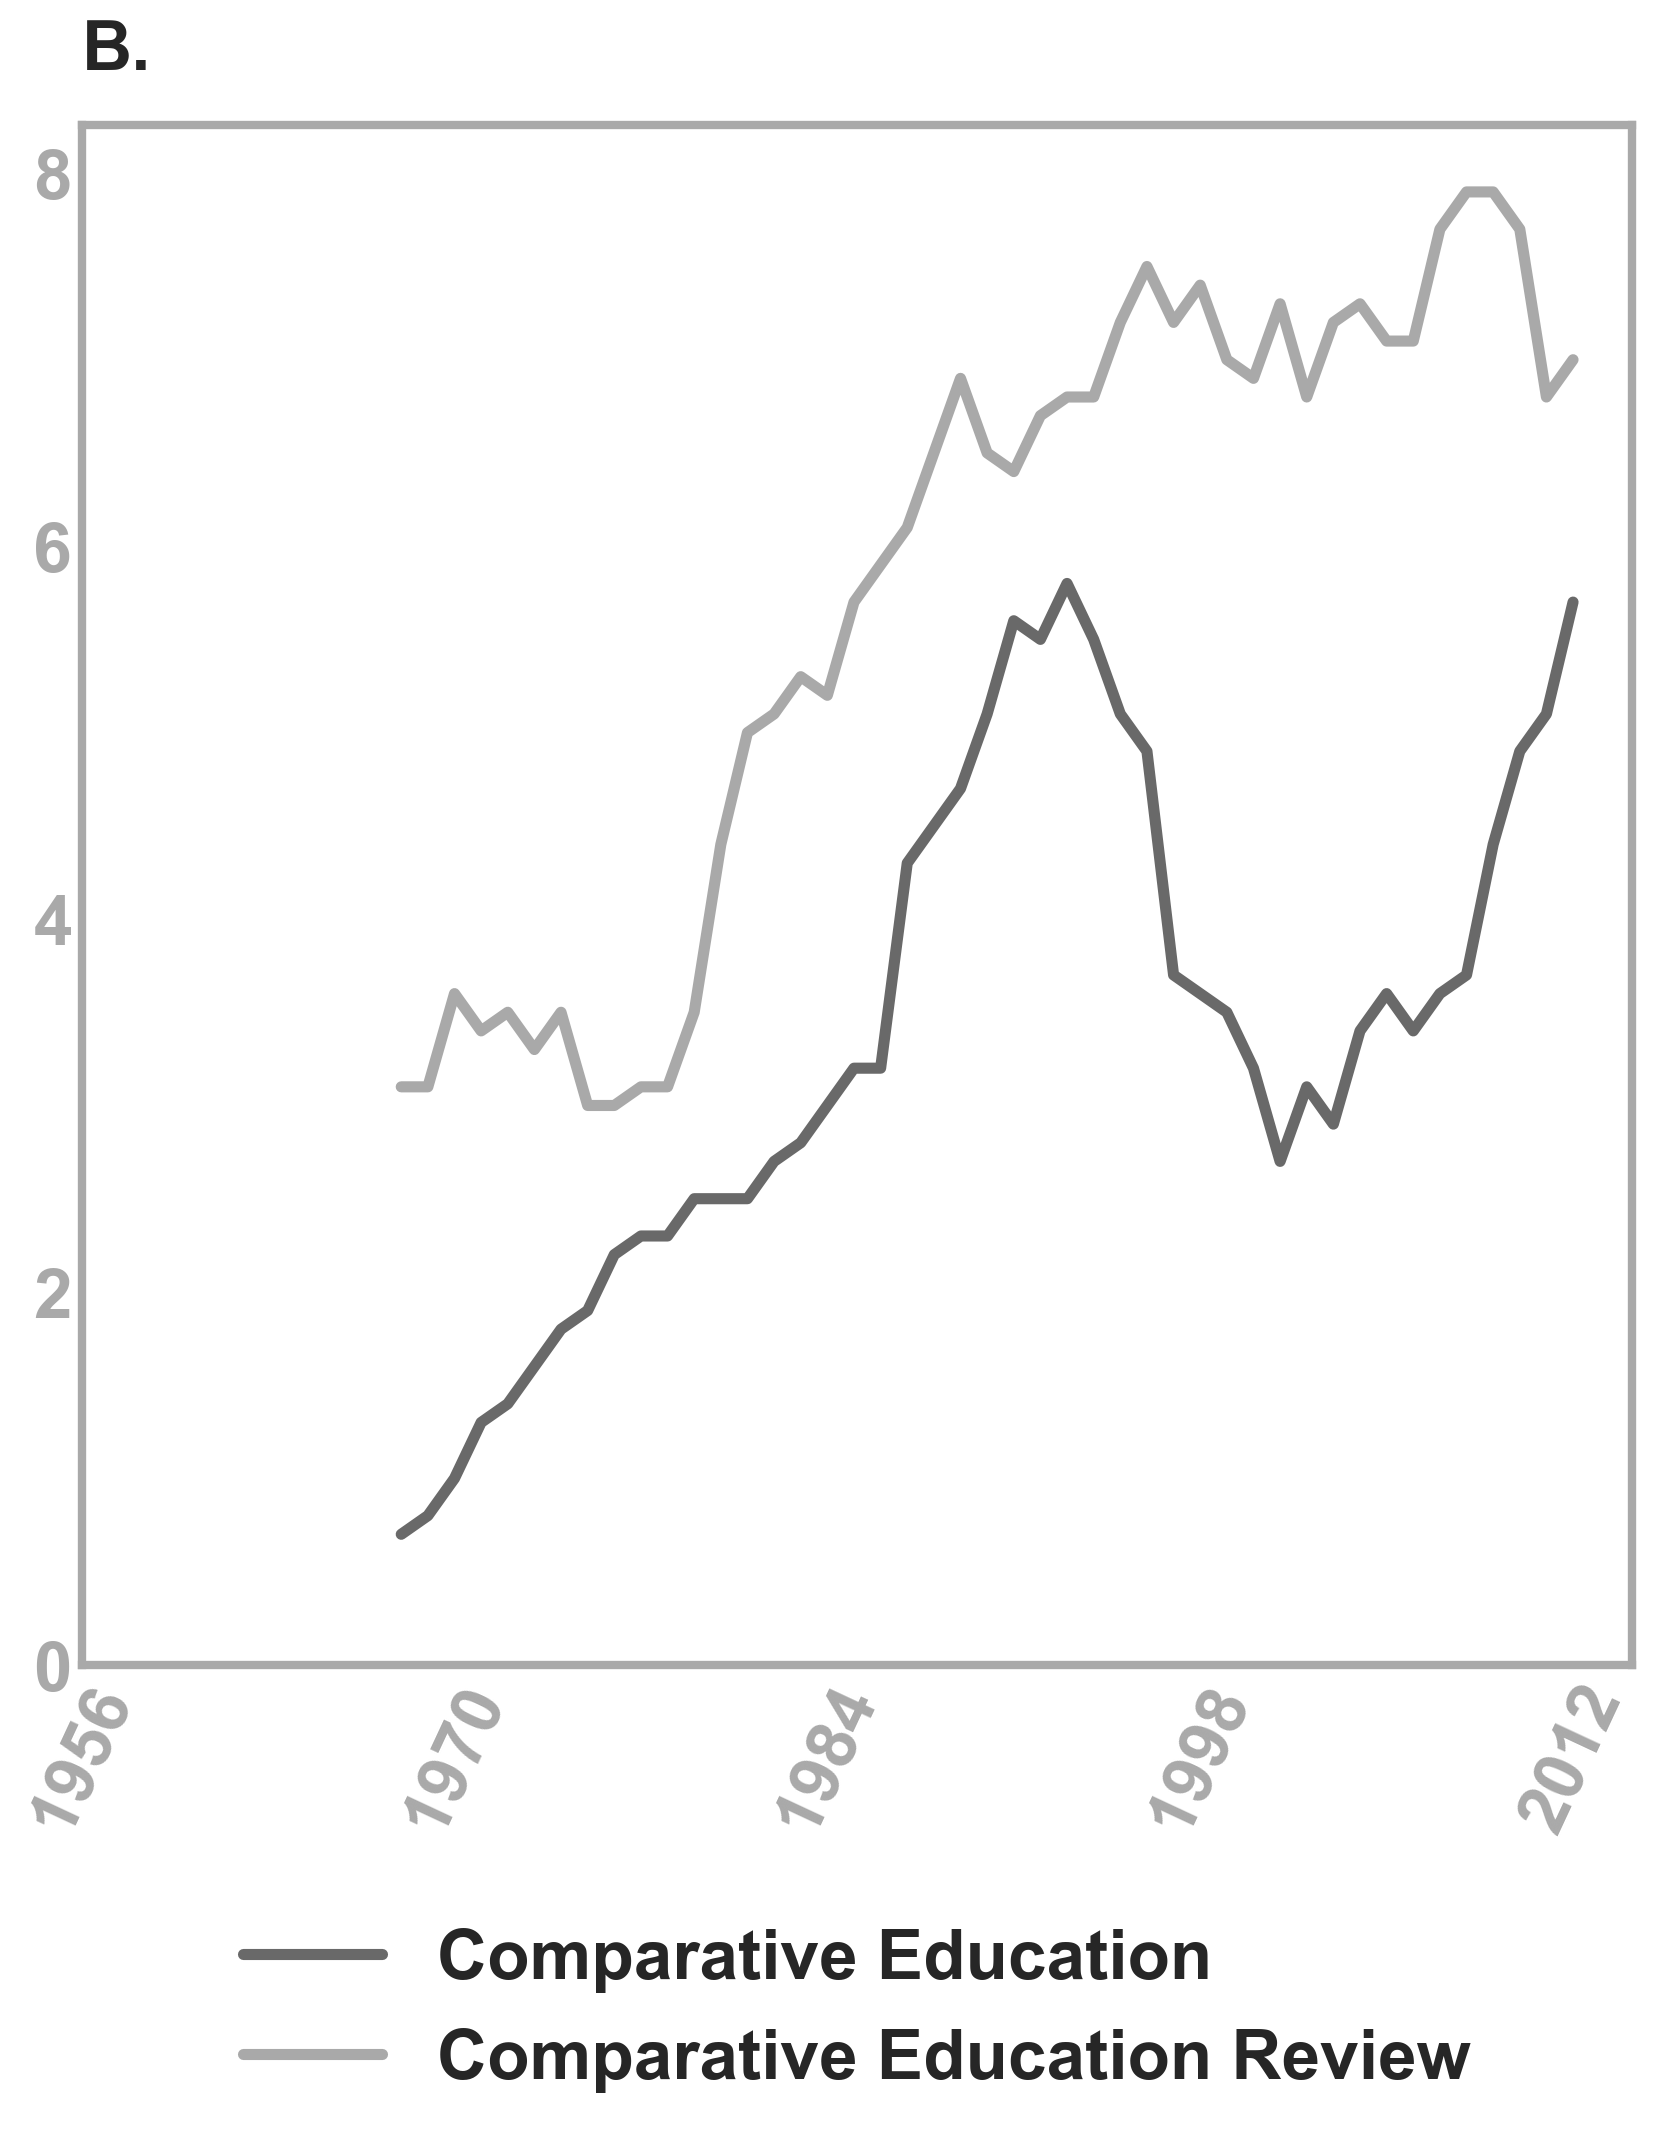

In [37]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": font_size}


# y = list(df.groupby('decade')['gender_article'].sum().sort_index())[:-1]
# x = sorted(df['decade'].unique())[:-1]
nyears = 10
y1a = list(ce.groupby("year")["gender_article"].sum())
y1b = rolling_mean(y1a, nyears)

y2a = list(cer.groupby("year")["gender_article"].sum())
y2b = rolling_mean(y2a, nyears)
x = ce["year"].unique()


plt.plot(
    x,
    y1b,
    # "-^",
    markerfacecolor="white",
    markersize=7,
    color=edge_color,
    label=f"Comparative Education",
    linewidth=4,
)
# plt.plot(x,y1a,
#          '-o',
#          color=edge_color,
#          label=f"(observed frequency)",
#          linewidth=0);
plt.plot(
    x,
    y2b,
    # "-o",
    markerfacecolor="white",
    markersize=5,
    color=tick_color,
    label=f"Comparative Education Review",
    linewidth=4,
)
# plt.plot(x,y2a,
#          '-o',
#          color=tick_color,
#          label=f"(observed frequency)",
#          linewidth=0);


# plt.ylabel('N Articles\non FGSS',
#            rotation=0,
#            labelpad=75,
#            size=font_size,
#            fontweight='bold',
#            va='center');
plt.yticks(range(0, 9, 2))
plt.xticks(range(1956, 2013, 14))
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax1.set_title("B.", loc="left", size=font_size, fontweight="bold", pad=20)
plt.show()

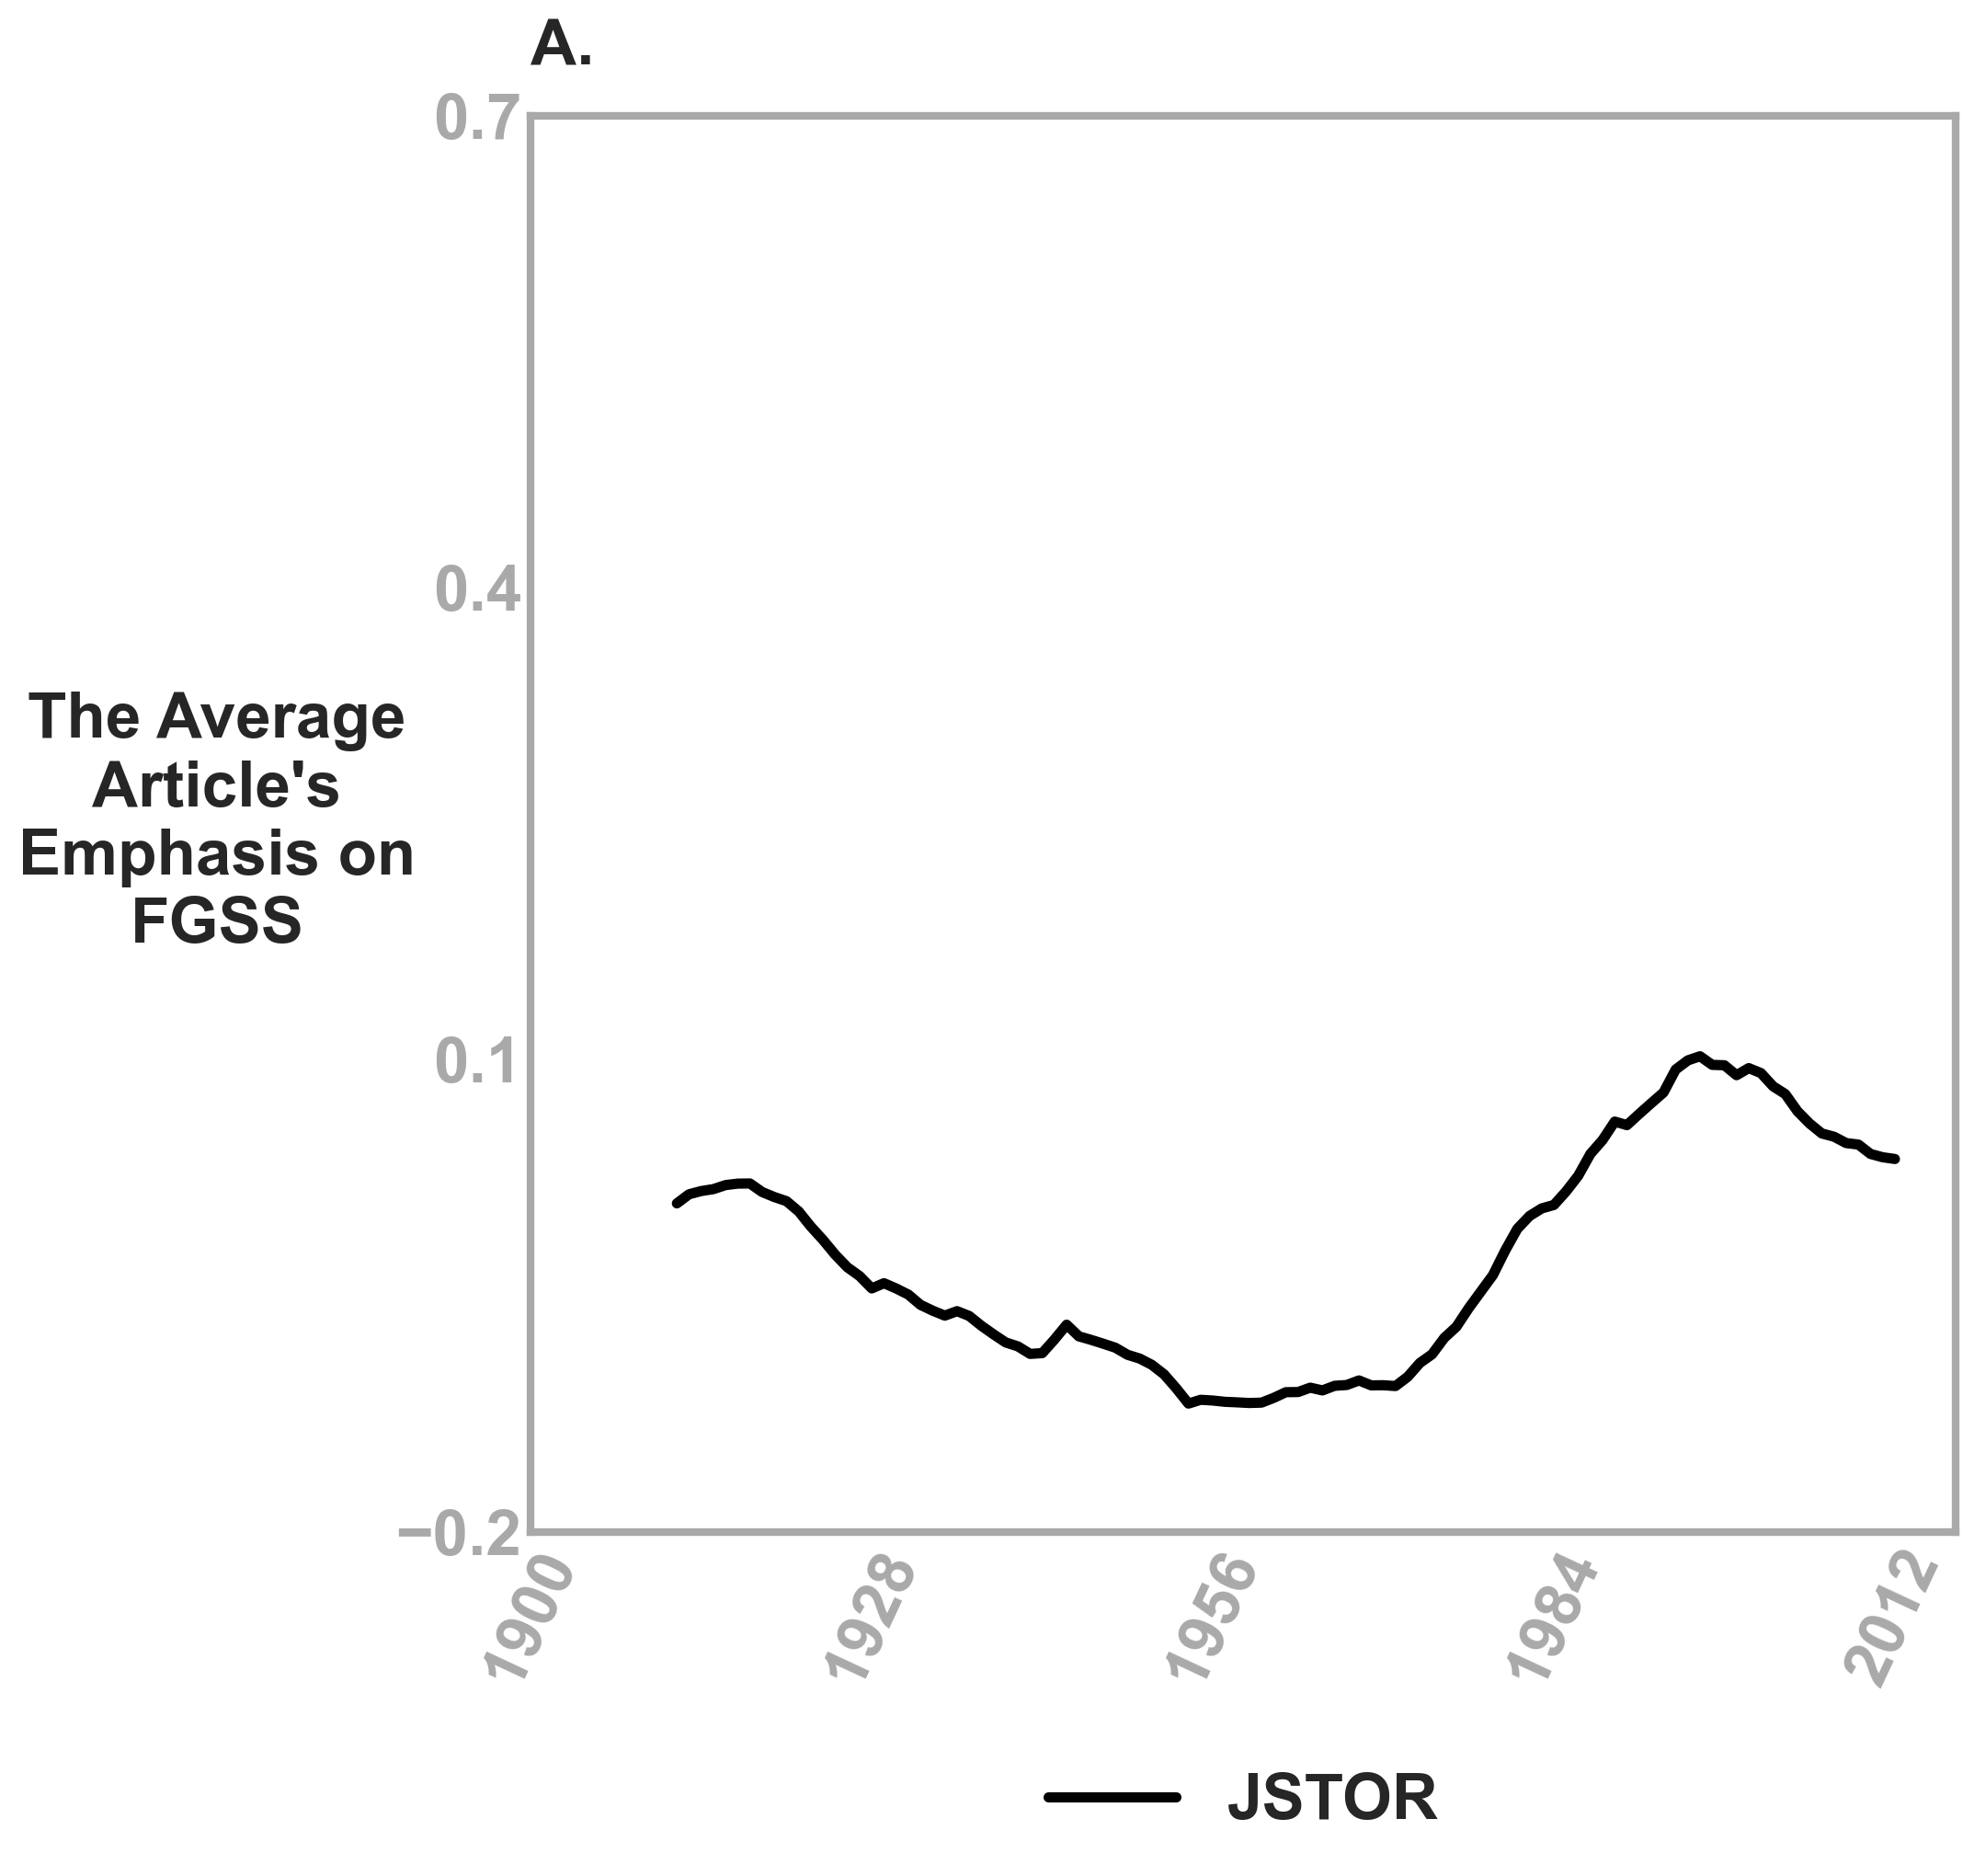

In [38]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25
fig, ax1 = plt.subplots()

# ax1.tick_params(axis = 'both', labelsize = font_size)


# plt.rc('axes', edgecolor='darkgray')
# plt.rc('xtick', color='darkgray')
# plt.rc('ytick', color='darkgray')

plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax2.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
plt.rc("axes", labelweight="bold")


nyears = 10
x = df["year"].unique()
y = list(df.groupby("year")["std_gender_topic"].mean())
y = rolling_mean(y, nyears)
y_label = "All Articles in JSTOR"
# y2 = list(cer.groupby('year')['std_gender_topic'].transform('mean'))
# y2_label = "All Articles in CER "
# y3 = list(ce.groupby('year')['std_gender_topic'].transform('mean'))
# y3_label = "All Articles in CE  "

plt.plot(x, y, color="black", label="JSTOR", linewidth=4)
# plt.plot(x, y2, color='black', label=y2_label, linewidth=2);
# plt.plot(x, y3, color='black', label=y3_label, linewidth=2);
plt.ylabel(
    "The Average\nArticle's\nEmphasis on\nFGSS",
    rotation=0,
    labelpad=70,
    size=font_size,
    fontweight="bold",
    va="center",
)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax1.set_title("A.", loc="left", size=font_size, fontweight="bold", pad=20)
plt.xticks(range(1900, 2013, 28))
plt.yticks(np.arange(-0.2, 0.71, 0.3))
plt.show()

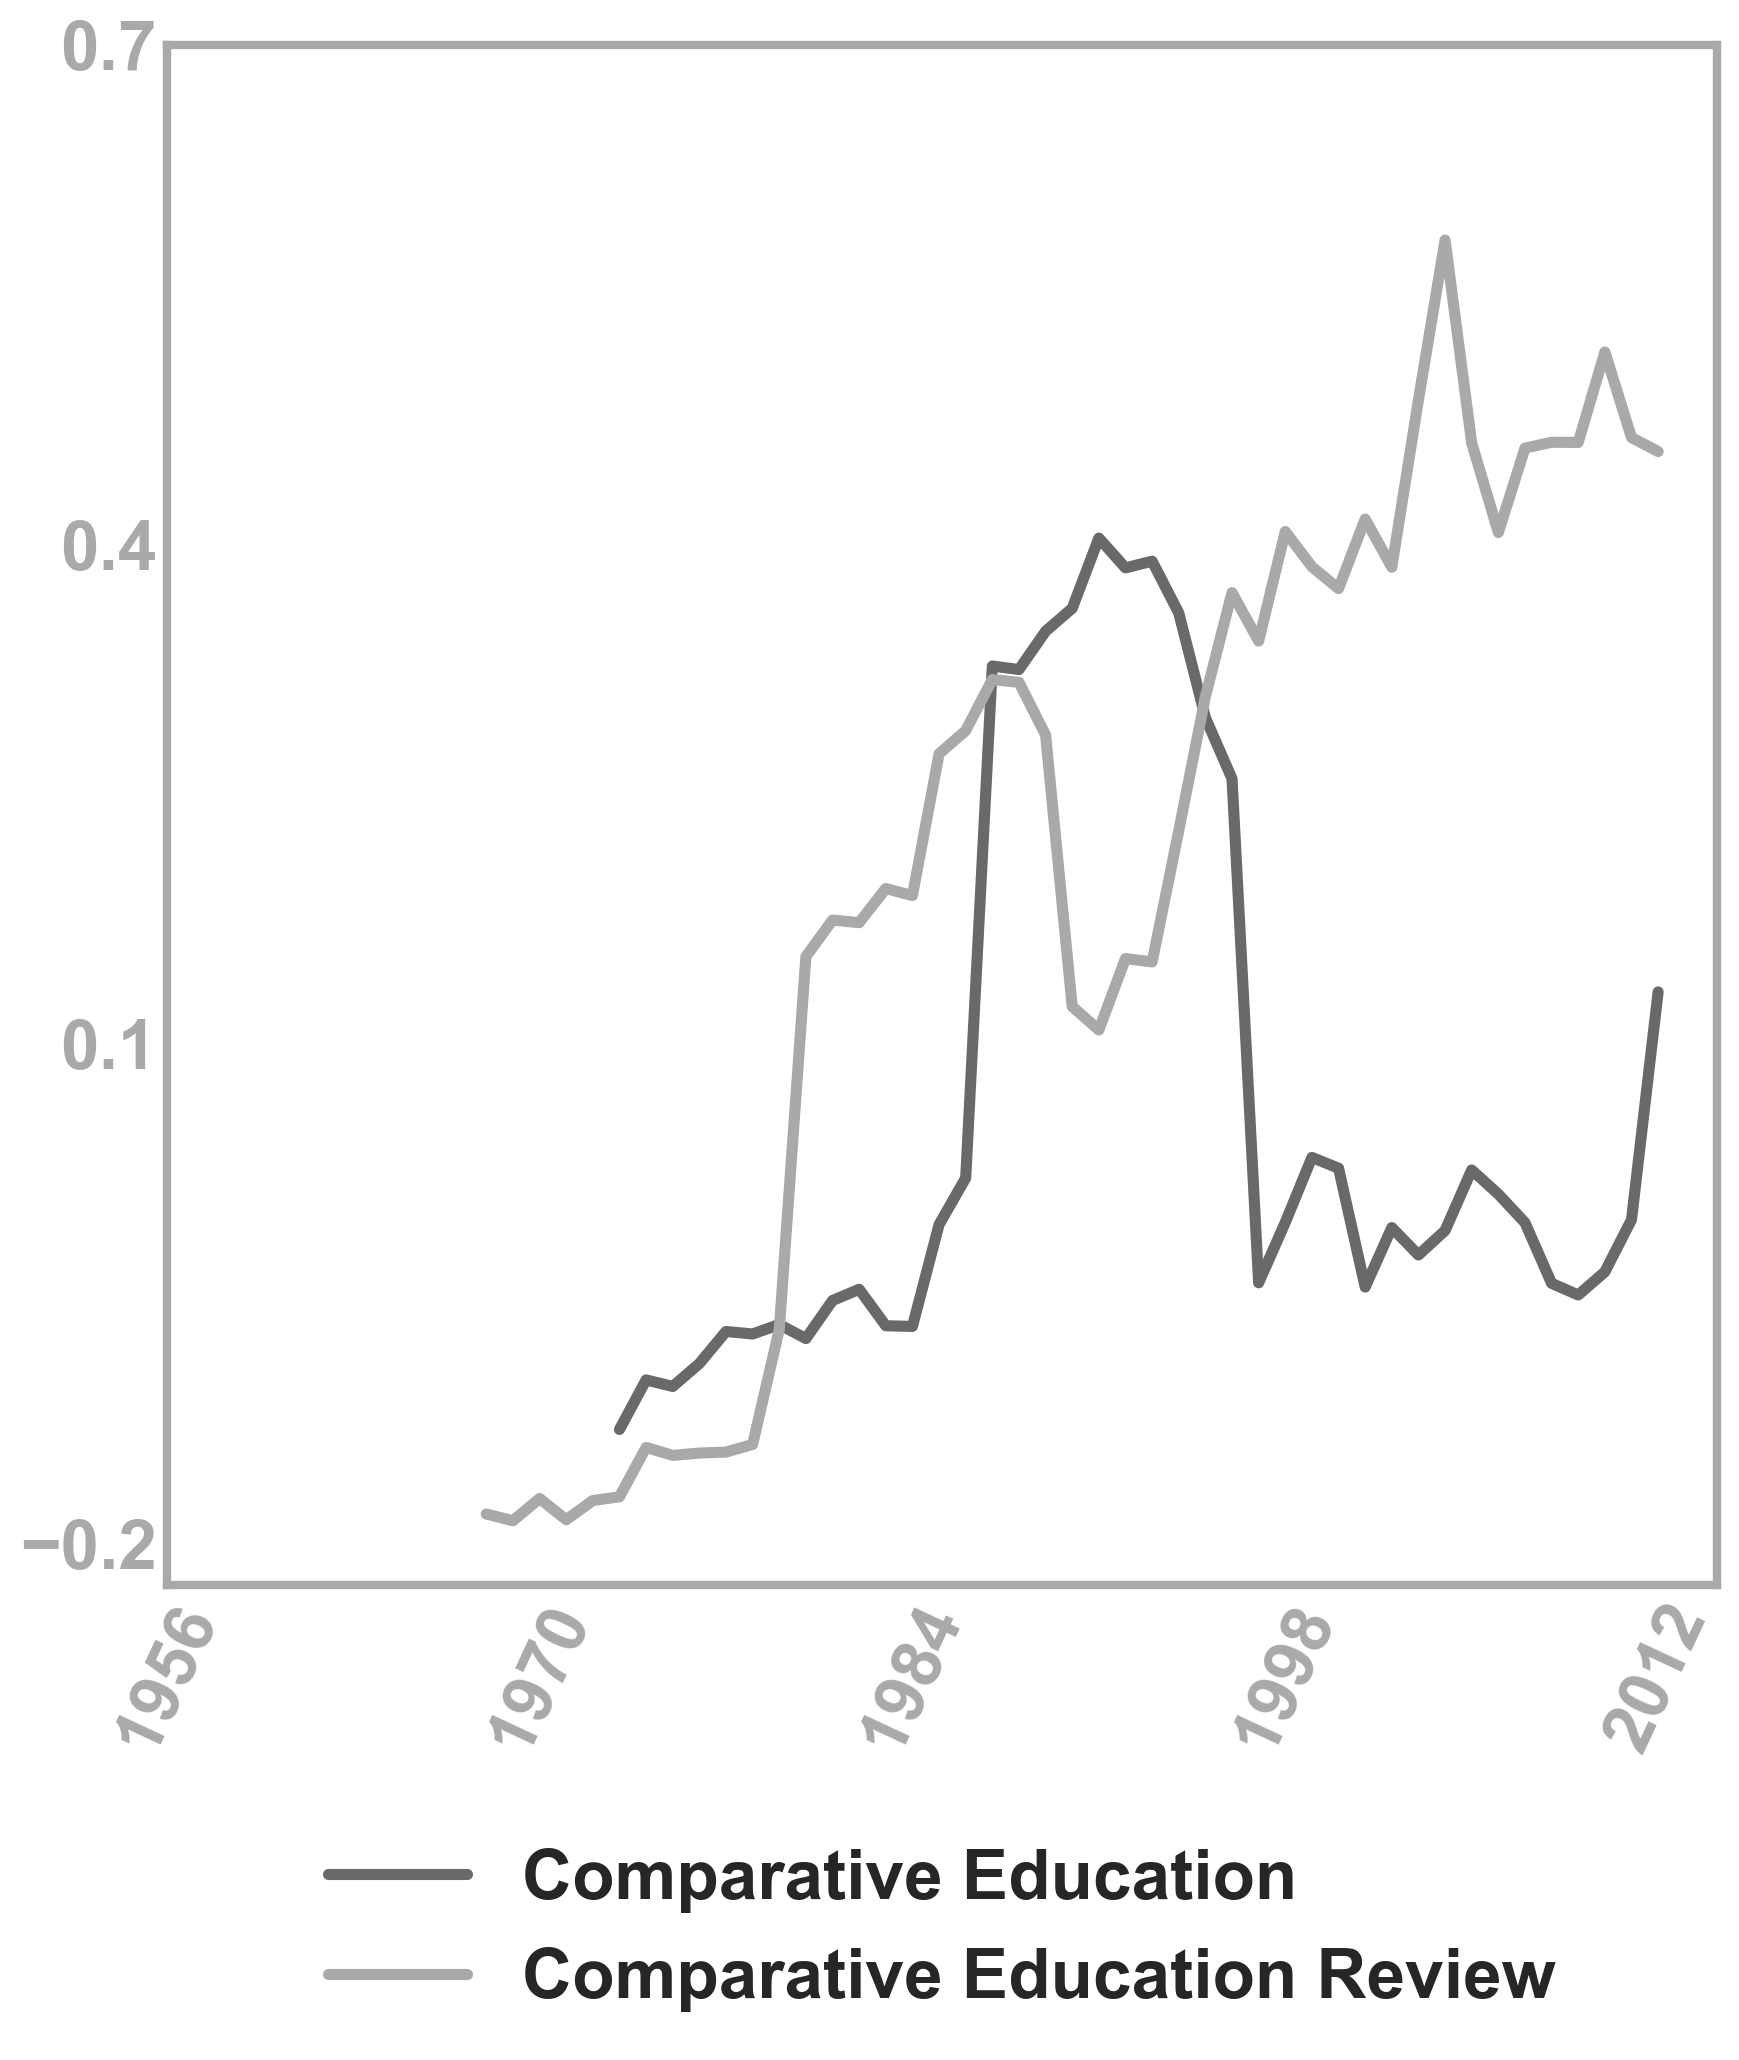

In [39]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25
fig, ax1 = plt.subplots()

# ax1.tick_params(axis = 'both', labelsize = font_size)


# plt.rc('axes', edgecolor='darkgray')
# plt.rc('xtick', color='darkgray')
# plt.rc('ytick', color='darkgray')

plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax2.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
plt.rc("axes", labelweight="bold")
legend_properties = {"weight": "bold", "size": font_size}

x = ce["year"].unique()


nyears = 10

# y = list(df.groupby('year')['std_gender_topic'].mean())
# y = rolling_mean(y, nyears)
# y_label = "All Articles in JSTOR"

# nyears = 10
# x = df['year'].unique()
y = list(df.groupby("year")["std_gender_topic"].mean())
y = rolling_mean(y, nyears)
y_label = "All Articles in JSTOR"


y2 = list(cer.groupby("year")["std_gender_topic"].mean())
y2 = rolling_mean(y2, nyears)
y2_label = "Comparative Education Review"

y3 = list(ce.groupby("year")["std_gender_topic"].mean())
y3 = rolling_mean(y3, nyears)
y3_label = "Comparative Education"

# plt.plot(df['year'].unique(), y,
#          color='black',
#          label=y_label,
#          linewidth=4);

plt.plot(
    x,
    y3,
    # "-^",
    markerfacecolor="white",
    markersize=7,
    color=edge_color,
    label=y3_label,
    linewidth=4,
)

plt.plot(
    x,
    y2,
    # "-o",
    markerfacecolor="white",
    markersize=5,
    color=tick_color,
    label=y2_label,
    linewidth=4,
)




# plt.ylabel("The Average\nArticle's\nEmphasis on\nFGSS",
#            rotation=0,
#            labelpad=70,
#            size=font_size,
#            fontweight='bold',
#            va='center');

plt.yticks(np.arange(-0.2, 0.71, 0.3))
plt.xticks(range(1956, 2013, 14))
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)

plt.show()

## Methods

In [40]:
df["std_emp"] = (df["emp"] - df["emp"].mean()) / df["emp"].std()
df["data_article"] = np.where((df["std_emp"] > 0), 1, 0)

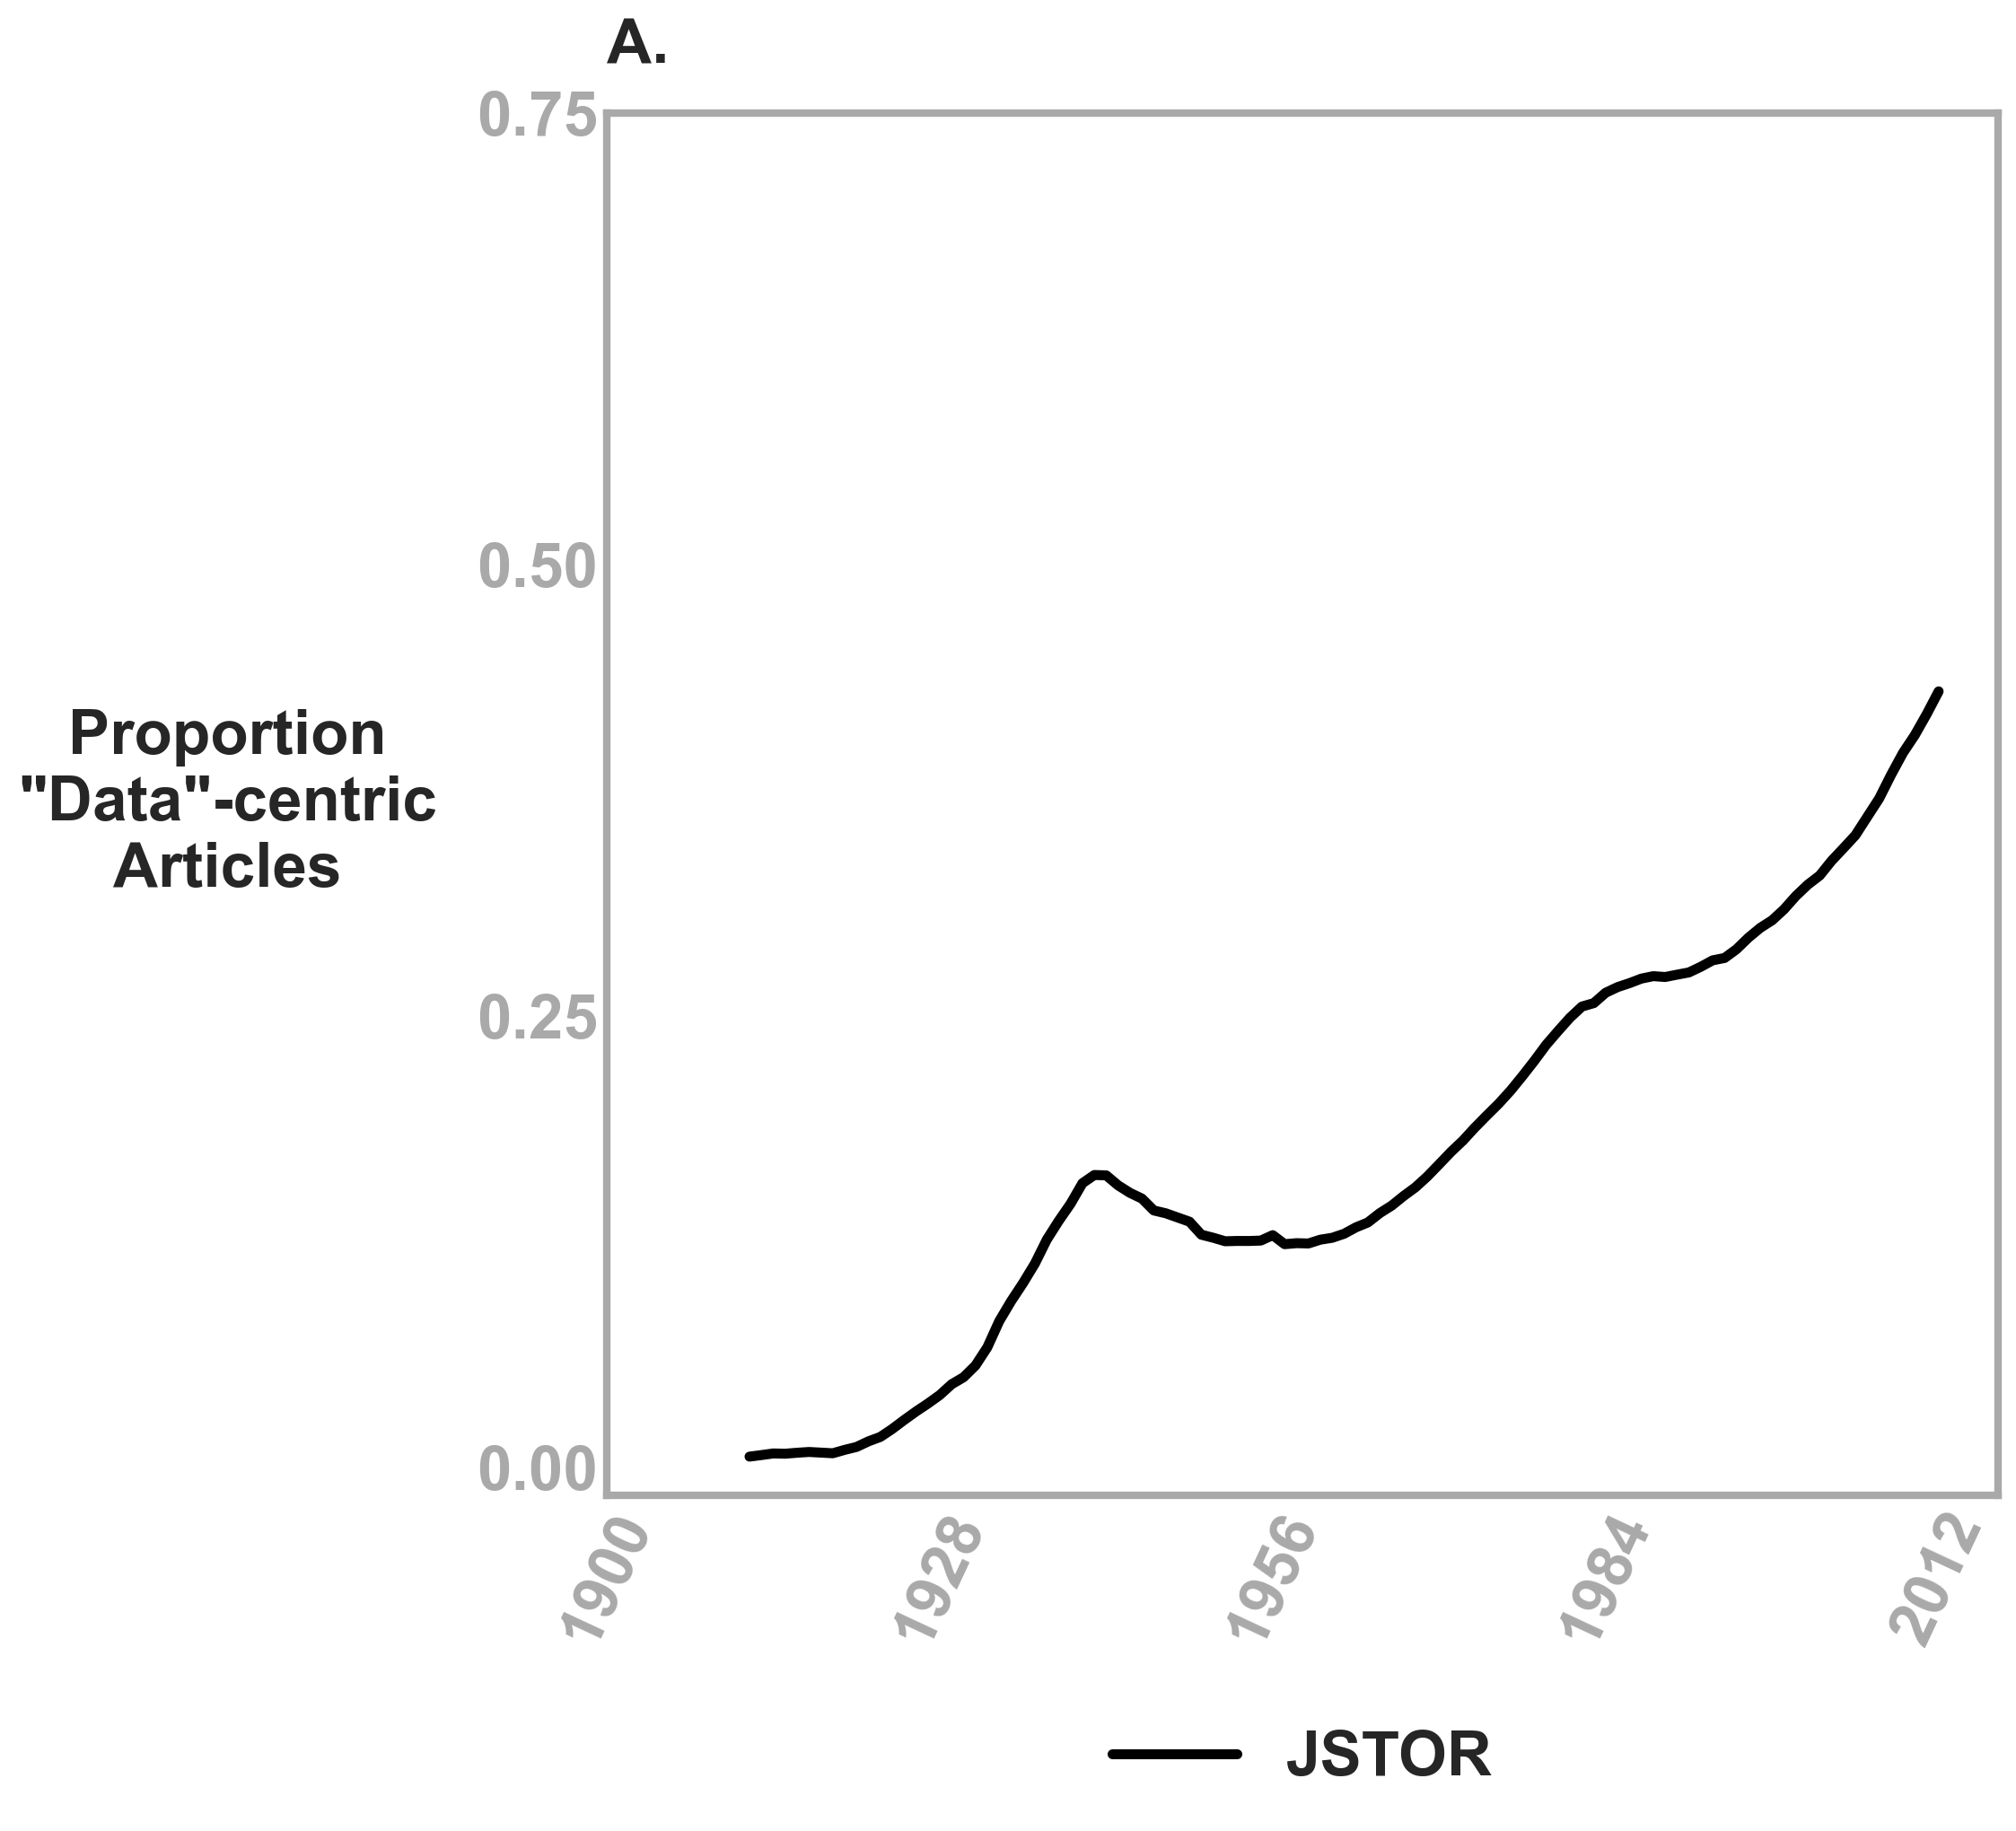

In [51]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": font_size}


nyears = 10
y = list(df.groupby("year")["data_article"].mean().sort_index())
y1 = rolling_mean(y, nyears)

# y = list(df.groupby('year')['gender_article'].transform('sum'))
x = df["year"].unique()
plt.plot(x, y1, color="black", linewidth=4, label=f"JSTOR")
# plt.plot(x,y, '-o', color=edge_color, linewidth=0, label="Observed frequency");
plt.ylabel(
    'Proportion\n"Data"-centric\nArticles',
    rotation=0,
    labelpad=100,
    size=font_size,
    fontweight="bold",
    va="center",
)
plt.yticks(np.arange(0,.76,.25));
plt.xticks(range(1900, 2013, 28))
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax1.set_title("A.", loc="left", size=font_size, fontweight="bold", pad=20)
plt.show()

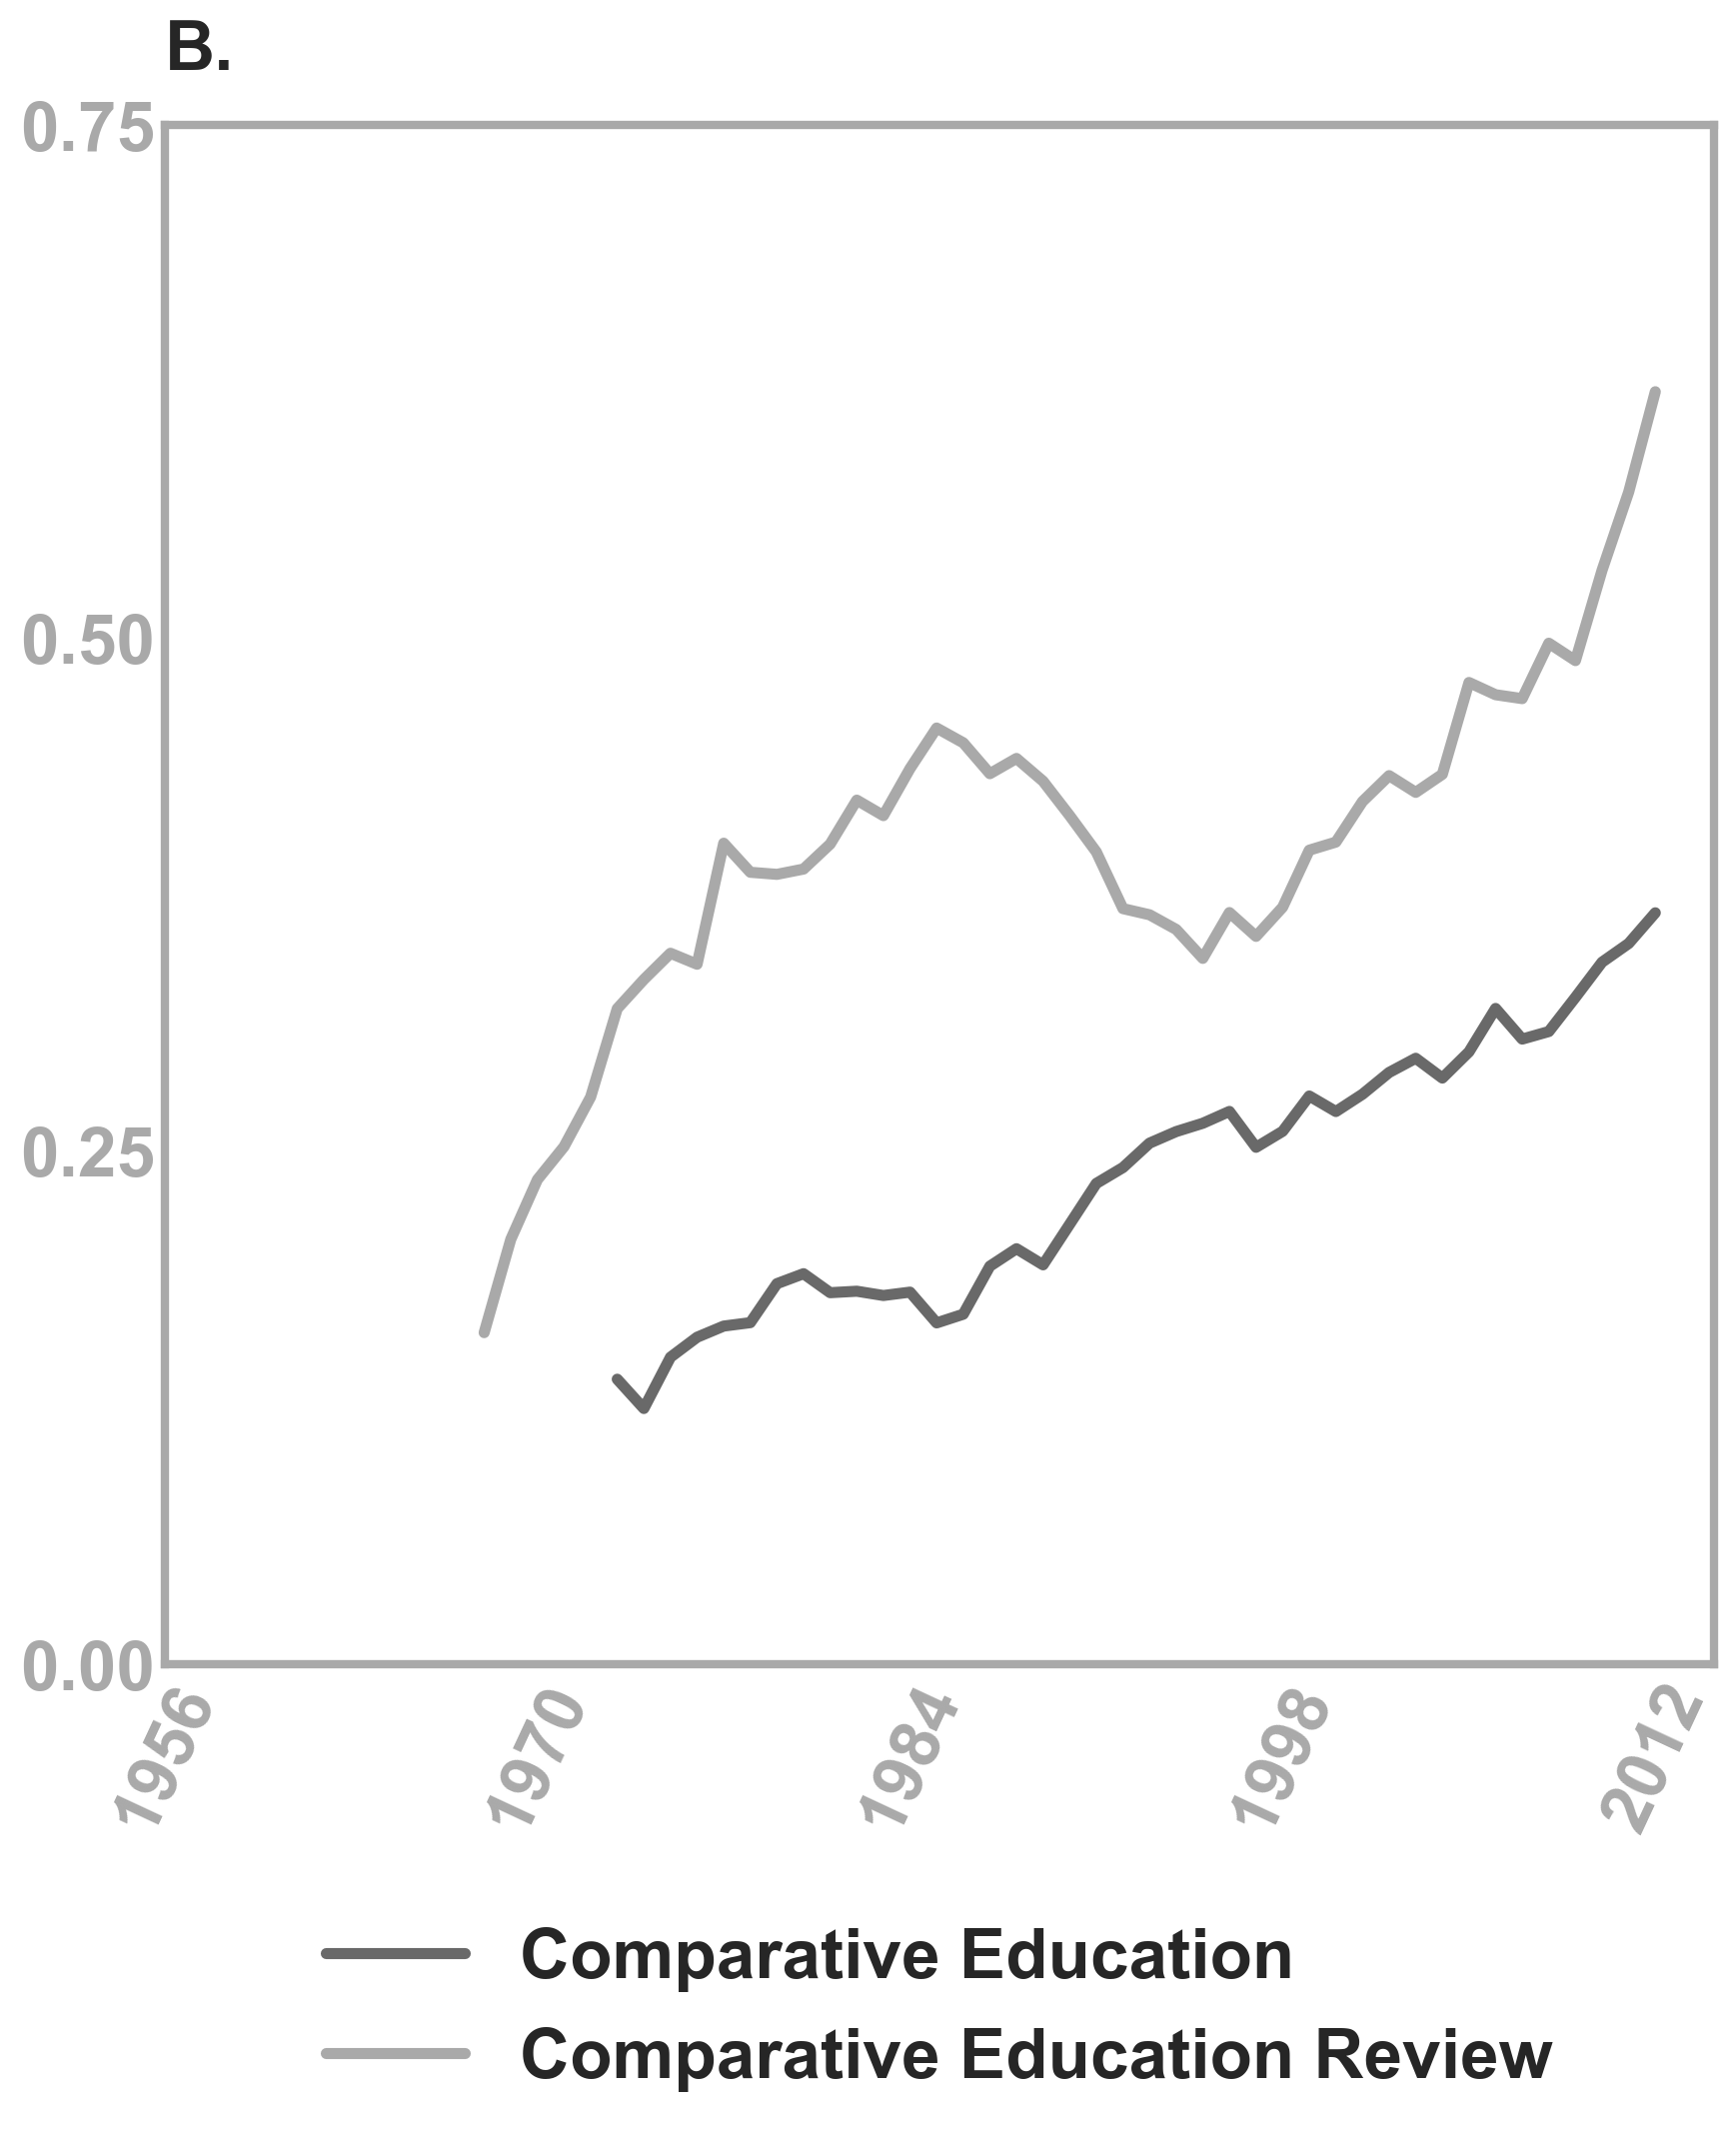

In [50]:
title_color, tick_color, edge_color, data_color = (
    "black",
    "darkgray",
    "dimgray",
    "whitesmoke",
)
font_weight = "bold"
font_size = 25

fig, ax1 = plt.subplots()
plt.rc("axes", edgecolor="darkgray")
plt.rc("xtick", color="darkgray")
plt.rc("ytick", color="darkgray")
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.setp(ax1.spines.values(), color=tick_color, lw=3)
plt.yticks(fontsize=font_size, rotation=0, fontweight="bold")
plt.xticks(fontsize=font_size, rotation=65, fontweight="bold")
legend_properties = {"weight": "bold", "size": font_size}


nyears = 10
y1 = list(ce.groupby("year")["data_article"].mean().sort_index())
y1 = rolling_mean(y1, nyears)
y1_label = "Comparative Education"
y2 = list(cer.groupby("year")["data_article"].mean().sort_index())
y2 = rolling_mean(y2, nyears)
y2_label = "Comparative Education Review"

# y = list(df.groupby('year')['gender_article'].transform('sum'))
x = cer["year"].unique()
plt.plot(x, y1, color=edge_color, linewidth=4, label=y1_label)
plt.plot(x, y2, color=tick_color, linewidth=4, label=y2_label)
# plt.plot(x,y, '-o', color=edge_color, linewidth=0, label="Observed frequency");
# plt.ylabel(
#     'Proportion\n"Data"-centric\nArticles',
#     rotation=0,
#     labelpad=100,
#     size=font_size,
#     fontweight="bold",
#     va="center",
# )
plt.yticks(np.arange(0,.76,.25));
plt.xticks(range(1956, 2013, 14))
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.13),
    fancybox=True,
    shadow=False,
    ncol=1,
    frameon=0,
    prop=legend_properties,
)
ax1.set_title("B.", loc="left", size=font_size, fontweight="bold", pad=20)
plt.show()